# Quantifying Optimal Stacking and the Effects of ADP Value

## Participant: Chris Wecht

Twitter: @ChrisWechtFF

## Introduction

The following analysis looks to quantify how we should be thinking about stacking and how to actually approach doing it relative to ADP. Does it make sense to reach for a QB if you have already invested in the offense earlier in the draft? Do you even need the QB? How many players should you have in a stack? It has already been proven that stacking and getting ADP value improves team performance. The goal of this analysis is to try and provide insights on when to forgo ADP value (or reach) or if you should be letting your stacks fall to you naturally at or past ADP.

## Utilities and Data Preparation

This section prepares the data for use throughout the analysis.

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib.ticker import FuncFormatter
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
pd.set_option('display.max_columns', None)

In [3]:
# Set the path to the folder containing the Regular Season CSV files
folder_path = r'C:\Users\cwech\Best_Ball_Data\BBM3\regular_season\fast'

# Initialize an empty list to store individual DataFrames
dfs = []

# Iterate over the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
fast_df = pd.concat(dfs, ignore_index=True)

folder_path = r'C:\Users\cwech\Best_Ball_Data\BBM3\regular_season\mixed'
dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dfs.append(df)
mixed_df = pd.concat(dfs, ignore_index=True)

# Import the QuarterFinals Data
folder_path = r'C:\Users\cwech\Best_Ball_Data\BBM3\postseason\quarterfinals'
dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dfs.append(df)
qtr_df = pd.concat(dfs, ignore_index=True)

# Import the SemiFinals Data
folder_path = r'C:\Users\cwech\Best_Ball_Data\BBM3\postseason\semifinals'
dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dfs.append(df)
semi_df = pd.concat(dfs, ignore_index=True)

# Import the Finals Data
folder_path = r'C:\Users\cwech\Best_Ball_Data\BBM3\postseason\finals'
dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dfs.append(df)
finals_df = pd.concat(dfs, ignore_index=True)

reg_df = pd.concat([fast_df,mixed_df], ignore_index=True)

## Create Closing Line ADP and Adjusted Draft Pick Curve

Closing line ADP is established to use to see how getting value on what is viewed as the "most accurate" ADP affects our stacks. The last two weeks of drafts from BBM3 were used to get the ADP of players drafted in that range.

Then an exponential curve was created that was fit to the average points scored by each pick number from BBM3 drafts. This creates an adjusted pick value that is more representative of getting ADP value or not on a pick.

In [4]:
# Convert 'draft_time' column to datetime objects
reg_df['draft_time'] = pd.to_datetime(reg_df['draft_time'])

# Find the latest date in the 'draft_time' column
latest_date = reg_df['draft_time'].max()

# Calculate the date two weeks earlier to get an accuracte representation of "Closing ADP"
two_weeks_earlier = latest_date - pd.Timedelta(weeks=2)
closing_ADP_df = reg_df[(reg_df['draft_time'] >= two_weeks_earlier) & (reg_df['draft_time'] <= latest_date)]

In [6]:
# Group the dataframe by 'overall_pick_number' and calculate the average pick_points for each group
avg_pick_points_df = reg_df.groupby('overall_pick_number')['pick_points'].mean().reset_index()

# Define the decreasing exponential function to fit the curve
def decreasing_exponential_curve(x, a, b):
    return a * np.exp(-b * x)

popt, _ = curve_fit(decreasing_exponential_curve, avg_pick_points_df['overall_pick_number'], avg_pick_points_df['pick_points'])
predicted_values = decreasing_exponential_curve(avg_pick_points_df['overall_pick_number'], *popt)
tss = np.sum((avg_pick_points_df['pick_points'] - avg_pick_points_df['pick_points'].mean())**2)
rss = np.sum((avg_pick_points_df['pick_points'] - predicted_values)**2)

# Calculate the R-squared value
r_squared = 1 - (rss / tss)

equation = f"y = {popt[0]:.2f} * exp(-{popt[1]:.2f}x)"
print("Equation of the decreasing exponential curve:")
print(equation)

print("R-squared value:")
print(r_squared)


Equation of the decreasing exponential curve:
y = 175.97 * exp(-0.01x)
R-squared value:
0.953334035201087


In [5]:
# Calculate adjusted pick values based on exponential curve
reg_df['adj_pick'] = decreasing_exponential_curve(reg_df['overall_pick_number'], *popt)
reg_df['adj_adp'] = decreasing_exponential_curve(reg_df['projection_adp'], *popt)

In [6]:
# Cleanup some of the closing ADP values when there are small samples of players
closing_ADP_grouped = closing_ADP_df.groupby('player_name')['overall_pick_number'].agg(['mean', 'count']).reset_index()

closing_ADP_grouped.rename(columns={'mean': 'closing_ADP', 'count': 'occurrences_count'}, inplace=True)

# Set 'closing_ADP' to 216 where 'occurrences_count' is less than 10
closing_ADP_grouped.loc[closing_ADP_grouped['occurrences_count'] < 10, 'closing_ADP'] = 216
closing_ADP_grouped.drop('occurrences_count', axis=1, inplace=True)

# Merge the closing_ADP_avg_df with reg_df based on the 'player_name' column
reg_df = pd.merge(reg_df, closing_ADP_grouped, on='player_name', how='left')

In [7]:
# Fill any null values in 'closing_ADP' with the max overall_pick_number
reg_df['closing_ADP'].fillna(216, inplace=True)
reg_df.loc[reg_df['projection_adp'] == 0, 'closing_ADP'] = 0
reg_df['adj_closing_adp'] = decreasing_exponential_curve(reg_df['closing_ADP'], *popt)
reg_df['adp_value'] = reg_df['overall_pick_number'] - reg_df['projection_adp']
reg_df['closing_adp_value'] = reg_df['overall_pick_number'] - reg_df['closing_ADP']
reg_df['adj_adp_value'] = reg_df['adj_adp'] - reg_df['adj_pick']
reg_df['adj_closing_adp_value'] = reg_df['adj_closing_adp'] - reg_df['adj_pick']

In [8]:
# Drop columns we will not need
columns_to_drop = ['team_pick_number', 'overall_pick_number', 'pick_order','projection_adp','pick_points',
                   'bye_week','position_name','tournament_round_number','tournament_round_draft_entry_id',
                  'draft_entry_id','clock','draft_id','draft_time']  # List of column names to drop

for df in [qtr_df, semi_df, finals_df]:
    df.drop(columns=columns_to_drop, inplace=True)
    
reg_df.drop(columns=['pick_order','bye_week','tournament_round_number','tournament_round_draft_entry_id',
                  'draft_entry_id','clock','draft_id','draft_time'], inplace=True)

In [9]:
#add prefix to each postseason dataframe headers to discern from each other and regular season
qtr_df = qtr_df.add_prefix('qtr_')
semi_df = semi_df.add_prefix('semi_')
finals_df = finals_df.add_prefix('finals_')

In [10]:
merged_df = reg_df.merge(qtr_df, left_on=['tournament_entry_id', 'player_name'], right_on=['qtr_tournament_entry_id', 'qtr_player_name'], how='left')
merged_df = merged_df.merge(semi_df, left_on=['tournament_entry_id', 'player_name'], right_on=['semi_tournament_entry_id', 'semi_player_name'], how='left')
merged_df = merged_df.merge(finals_df, left_on=['tournament_entry_id', 'player_name'], right_on=['finals_tournament_entry_id', 'finals_player_name'], how='left')

In [11]:
# Group the dataframe by 'tournament_entry_id' and calculate the sum and average for the specified columns
grouped_df = merged_df.groupby('tournament_entry_id').agg(
    sum_adp_value=('adp_value', 'sum'),
    avg_adp_value=('adp_value', 'mean'),
    sum_closing_adp_value=('closing_adp_value', 'sum'),
    avg_closing_adp_value=('closing_adp_value', 'mean'),
    sum_adj_adp_value=('adj_adp_value', 'sum'),
    avg_adj_adp_value=('adj_adp_value', 'mean'),
    sum_adj_closing_adp_value=('adj_closing_adp_value', 'sum'),
    avg_adj_closing_adp_value=('adj_closing_adp_value', 'mean'),
    max_roster_points=('roster_points', 'max'),
    qtr_team=('qtr_playoff_team', 'max'),
    semi_team=('semi_playoff_team', 'max'),
    finals_team=('finals_playoff_team', 'max')
)

# Reset the index of the resulting dataframe
grouped_df = grouped_df.reset_index()

## Choosing ADP Value Data Points

In the next figure 8 different forms of ADP value data points were plotted in intervals against advance rate. As expected, having a positive ADP on the team leads to higher advance rates. The adjusted ADP values show slightly stronger correlations to advance rate than the non-adjusted ADP values. Also, the summed up ADP values perform better than taking the average of every picks' ADP value. For the rest of this analysis, we will focus on using sum_closing_adp_value to test against closing ADP and sum_adp_value to better test what the drafter sees from an overall ADP perspective at the time of the drafts.

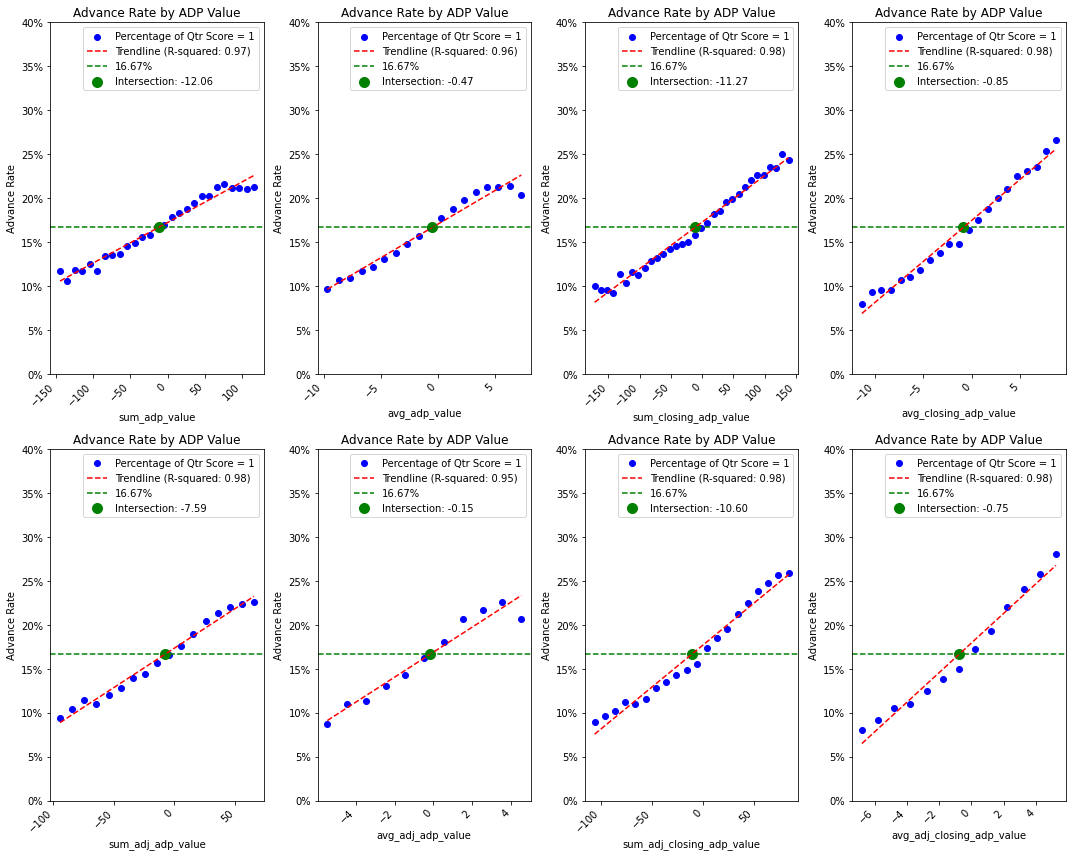

In [12]:
# Define the interval range for each column
interval_range = {
    'sum_adp_value': 10,
    'avg_adp_value': 1,
    'sum_closing_adp_value': 10,
    'avg_closing_adp_value': 1,
    'sum_adj_adp_value': 10,
    'avg_adj_adp_value': 1,
    'sum_adj_closing_adp_value': 10,
    'avg_adj_closing_adp_value': 1
}

# Dictionary to store the x_intersection for each column
x_intersections = {}

# Minimum number of rows required in each bin
min_bin_rows = 2500

min_values = grouped_df.min()
max_values = grouped_df.max()

# Create bins with a defined interval range for each column
for col, interval in interval_range.items():
    bins = pd.interval_range(start=min_values[col], end=max_values[col], freq=interval)
    grouped_df[f'{col}_bin'] = pd.cut(grouped_df[col], bins=bins, include_lowest=True)
    
# Calculate the percentage of rows with qtr_team = 1 for each bin
plt.figure(figsize=(15, 12))
for i, col in enumerate(interval_range.keys(), 1):
    plt.subplot(2, 4, i)
    counts = grouped_df.groupby(f'{col}_bin').size()
    qtr_percentage = (grouped_df.groupby(f'{col}_bin')['qtr_team'].sum() / counts) * 100
    
    # Filter out bins that have fewer rows than the minimum threshold
    qtr_percentage = qtr_percentage[counts >= min_bin_rows]
    counts = counts[counts >= min_bin_rows]
    
    # Convert interval labels to their midpoint values for plotting
    bin_midpoints = [interval.mid for interval in qtr_percentage.index]
    plt.scatter(bin_midpoints, qtr_percentage, label='Percentage of Qtr Score = 1', color='b')
    
    # Fit a linear trendline if there are enough data points in the bin
    if len(qtr_percentage) > 1:
        z = np.polyfit(bin_midpoints, qtr_percentage, 1)
        p = np.poly1d(z)
        slope = z[0]
        plt.plot(bin_midpoints, p(bin_midpoints), 'r--', label=f'Trendline (R-squared: {r2_score(qtr_percentage, p(bin_midpoints)):.2f})')
        
         # Draw the horizontal line at y = 16.67%
        plt.axhline(y=16.67, color='green', linestyle='--', label='16.67%')
        
        # Find the x value when the trendline intersects with the horizontal line
        x_intersection = (16.67 - z[1]) / z[0]
        plt.scatter(x_intersection, 16.67, color='green', marker='o', s=100, label=f'Intersection: {x_intersection:.2f}')
        x_intersections[col] = x_intersection  # Store the x_intersection in the dictionary
    
    plt.ylim(0, 40)  
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(f'{col}')
    plt.ylabel('Advance Rate')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
    plt.title(f'Advance Rate by ADP Value')
    plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Read in CSV with player teams
file_path = r'C:\Users\cwech\Best_Ball_Data\BBM3\BBM3_teams.csv'
player_teams = pd.read_csv(file_path)

In [14]:
# Perform the merge to get players with their team at the time of drafts. For the purpose of this study
# player teams were the team they would have been on when drafts were happening before the season
# Ex. T.J. Hockenson is listed on DET not MIN
merged_df_with_player_teams = pd.merge(merged_df, player_teams, on='player_name', how='left')
merged_df_with_player_teams['top_48_pick'] = np.where(merged_df_with_player_teams['overall_pick_number'] <= 48,1,0)
merged_df_with_player_teams['rd120_later_pick'] = np.where(merged_df_with_player_teams['overall_pick_number'] > 120,1,0)
merged_df_with_player_teams['QB_big_reach'] = np.where(((merged_df_with_player_teams['adj_adp_value'] <=-15) & (merged_df_with_player_teams['position_name'] == 'QB')),1,0)

## Acquiring the Stack Data

Player teams were determined in a separate csv and were chosen based on the team the player was on before the season started. For example, T.J. Hockenson is listed as on the Lions because that is what the drafter would have anticipated for his team when they were drafting.

In [15]:
# Group the dataframe by 'tournament_entry_id' and 'team' columns to identify stacks within rosters
stacks_df = merged_df_with_player_teams.groupby(['tournament_entry_id', 'team']).agg(
    num_players=('player_name', 'nunique'),
    sum_48_picks=('top_48_pick', 'sum'),
    sum_120_picks=('rd120_later_pick', 'sum'),
    sum_adj_adp_value=('adj_adp_value', 'sum'),
    sum_adj_closing_adp_value=('adj_closing_adp_value', 'sum'),
    big_QB_reach=('QB_big_reach', 'max'),
    roster_points=('roster_points', 'max'),
    qtr_roster_points=('qtr_roster_points', 'max'),
    semi_roster_points=('semi_roster_points', 'max'),
    finals_roster_points=('finals_roster_points', 'max'),
    qtr_team=('qtr_playoff_team', 'max'),
    semi_team=('semi_playoff_team', 'max'),
    finals_team=('finals_playoff_team', 'max'),
    player_names=('player_name', lambda x: ', '.join(sorted(x.unique()))),
    positions=('position_name', lambda x: ', '.join(sorted(x)))
)

stacks_df = stacks_df.reset_index()

# Filter out rows with num_players < 3
stacks_df = stacks_df[stacks_df['num_players'] >= 3]
# Filter out rows with team value 'FA'
stacks_df = stacks_df[stacks_df['team'] != 'FA']
stacks_df = stacks_df.sort_values(by='roster_points', ascending=False)

#Check if the 'positions' column contains the text "QB" and set the 'include_QB' column
stacks_df['include_QB'] = stacks_df['positions'].str.contains('QB').astype(int)

stacks_df['qtr_team'].fillna(0, inplace=True)
stacks_df['semi_team'].fillna(0, inplace=True)
stacks_df['finals_team'].fillna(0, inplace=True)


## Analyzing Stack Sizes

The first analysis performed was on stack sizes. Stacks must have included three players from the same team to be considered

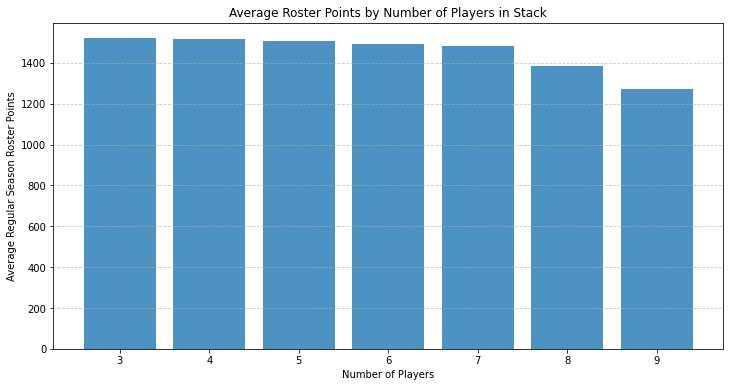

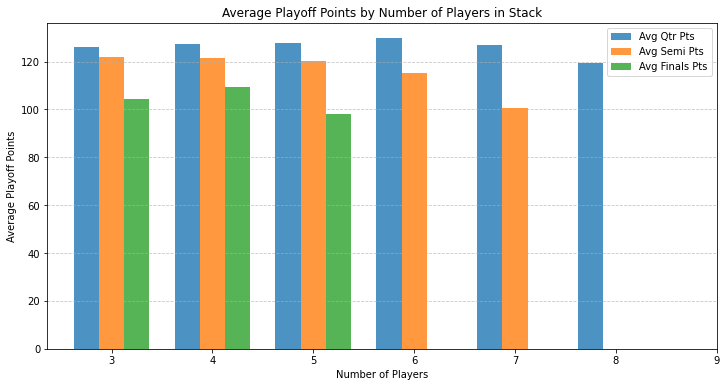

In [16]:
roster_points_cols = ['roster_points']
other_points_cols = ['qtr_roster_points', 'semi_roster_points', 'finals_roster_points']
other_points_labels = ['Avg Qtr Pts', 'Avg Semi Pts', 'Avg Finals Pts']

# Create a dictionary to store the results for each column
avg_roster_points = {}

# Group the dataframe by 'num_players' and calculate the mean of each roster points column for each group
for col in roster_points_cols + other_points_cols:
    grouped_df = stacks_df.groupby('num_players')[col].mean().reset_index()
    avg_roster_points[col] = grouped_df

plt.figure(figsize=(12, 6))
width = 0.25
plt.bar(avg_roster_points['roster_points']['num_players'], avg_roster_points['roster_points']['roster_points'], 
        alpha=0.8, label="Stacks")

plt.xlabel('Number of Players')
plt.ylabel('Average Regular Season Roster Points')
plt.title('Average Roster Points by Number of Players in Stack')
plt.xticks(avg_roster_points['roster_points']['num_players'], avg_roster_points['roster_points']['num_players'])

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
for idx, col in enumerate(other_points_cols):
    plt.bar(avg_roster_points[col]['num_players'] + idx * width, avg_roster_points[col][col], 
            label=other_points_labels[idx], alpha=0.8, width=width)

plt.xlabel('Number of Players')
plt.ylabel('Average Playoff Points')
plt.title('Average Playoff Points by Number of Players in Stack')
plt.xticks(avg_roster_points['roster_points']['num_players'] + width, avg_roster_points['roster_points']['num_players'])
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


When it comes the regular season, we start to see a drop in average roster points once we get to 6 players from the same team. That becomes even more apparent when we look at the playoff weeks. Quarter Finals average points holds up well until you get to 7 and 8 player stacks, but we see quick declines in average Semi Finals points after 5-man stacks. Average Finals points is even worse with the decline beginning at 5-man stacks and no 6-man or larger stacks even made the finals.  

This makes sense because as you advance through the playoffs the field gets stronger and stronger. You are going to need to have more of a "optimal" roster as you go and having 5+ players from the same team makes that difficult. It is hard for 5 or more teammates to all put up ceiling weeks in the same week. 

While larger stacks can be okay in regular season, they really struggle to compete in the playoffs weeks giving an edge to smaller 3 and 4-man stacks.

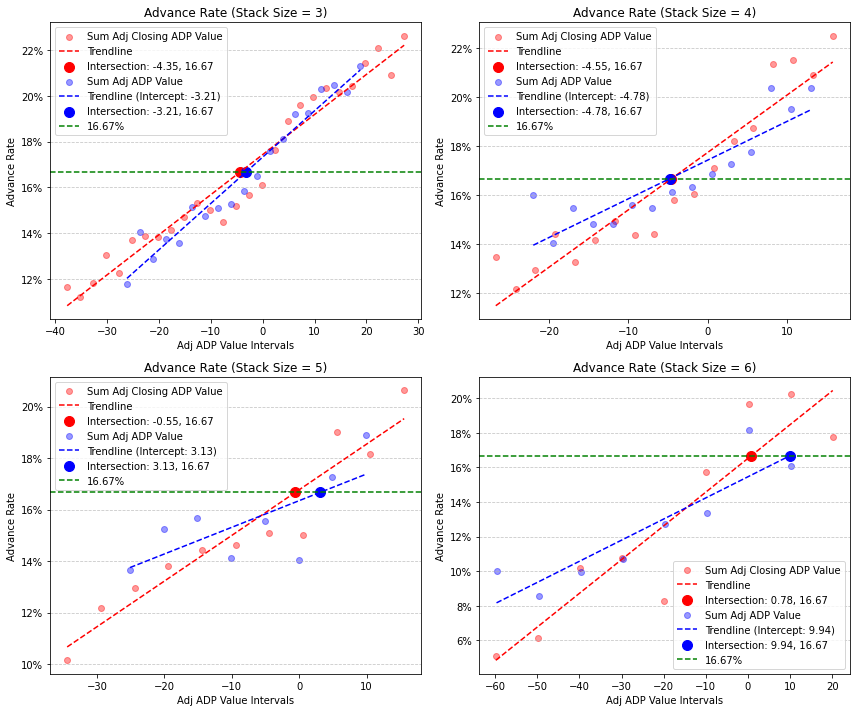

In [17]:
# Initialize dictionaries to store the x-intersection values for each num_players
x_intersections_closing = {}
x_intersections_adp = {}

# Define the interval range for sum_adj_closing_adp_value and sum_adj_adp_value bins
interval_range_closing = [2.5, 2.5, 5, 10]
interval_range_adp = [2.5, 2.5, 5, 10]

# Set the minimum bin count
min_bin_count = [1500, 1500, 500, 50]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Loop through num_players = 3, 4, 5, and 6
for num_players, ax in zip([3, 4, 5, 6], axs.flatten()):
    filtered_df = stacks_df[stacks_df['num_players'] == num_players]
    min_value_closing = filtered_df['sum_adj_closing_adp_value'].min()
    max_value_closing = filtered_df['sum_adj_closing_adp_value'].max()

    # Create bins with a defined interval range for sum_adj_closing_adp_value
    bins_closing = pd.interval_range(start=min_value_closing, end=max_value_closing, freq=interval_range_closing[num_players-3])

    # Calculate the percentage of rows with qtr_team = 1 for each bin of sum_adj_closing_adp_value
    result_df_closing = filtered_df.groupby(pd.cut(filtered_df['sum_adj_closing_adp_value'], bins=bins_closing))['qtr_team'].mean() * 100

    # Calculate the count for each bin
    bin_counts_closing = filtered_df.groupby(pd.cut(filtered_df['sum_adj_closing_adp_value'], bins=bins_closing)).size()

    # Filter out bins with a count below the minimum bin count
    valid_bins_closing = bin_counts_closing[bin_counts_closing >= min_bin_count[num_players-3]]
    result_df_closing = result_df_closing.loc[result_df_closing.index.isin(valid_bins_closing.index)]

    bin_midpoints_closing = [(interval.left + interval.right) / 2 for interval in result_df_closing.index]
    ax.scatter(bin_midpoints_closing, result_df_closing.values, alpha=0.4, label='Sum Adj Closing ADP Value', color='red')

    # Calculate the trendline coefficients using numpy.polyfit
    z_closing = np.polyfit(bin_midpoints_closing, result_df_closing.values, 1)
    p_closing = np.poly1d(z_closing)

    # Calculate the intercept point with the trendline and the horizontal line at y = 16.67
    intercept_x_closing = (16.67 - z_closing[1]) / z_closing[0]
    intercept_y_closing = p_closing(intercept_x_closing)
    ax.plot(bin_midpoints_closing, p_closing(bin_midpoints_closing), 'r--', label=f'Trendline')
    ax.scatter(intercept_x_closing, intercept_y_closing, color='red', marker='o', s=100, label=f'Intersection: {intercept_x_closing:.2f}, {intercept_y_closing:.2f}')

    min_value_adp = filtered_df['sum_adj_adp_value'].min()
    max_value_adp = filtered_df['sum_adj_adp_value'].max()

    bins_adp = pd.interval_range(start=min_value_adp, end=max_value_adp, freq=interval_range_adp[num_players-3])
    result_df_adp = filtered_df.groupby(pd.cut(filtered_df['sum_adj_adp_value'], bins=bins_adp))['qtr_team'].mean() * 100
    bin_counts_adp = filtered_df.groupby(pd.cut(filtered_df['sum_adj_adp_value'], bins=bins_adp)).size()
    valid_bins_adp = bin_counts_adp[bin_counts_adp >= min_bin_count[num_players-3]]
    result_df_adp = result_df_adp.loc[result_df_adp.index.isin(valid_bins_adp.index)]

    bin_midpoints_adp = [(interval.left + interval.right) / 2 for interval in result_df_adp.index]
    ax.scatter(bin_midpoints_adp, result_df_adp.values, alpha=0.4, label='Sum Adj ADP Value', color='blue')

    # Calculate the trendline coefficients using numpy.polyfit for sum_adj_adp_value
    z_adp = np.polyfit(bin_midpoints_adp, result_df_adp.values, 1)
    p_adp = np.poly1d(z_adp)

    # Calculate the intercept point with the trendline and the horizontal line at y = 16.67 for sum_adj_adp_value
    intercept_x_adp = (16.67 - z_adp[1]) / z_adp[0]
    intercept_y_adp = p_adp(intercept_x_adp)
    
    x_intersections_closing[num_players] = intercept_x_closing
    x_intersections_adp[num_players] = intercept_x_adp

   
    ax.plot(bin_midpoints_adp, p_adp(bin_midpoints_adp), 'b--', label=f'Trendline (Intercept: {intercept_x_adp:.2f})')
    ax.scatter(intercept_x_adp, intercept_y_adp, color='blue', marker='o', s=100, label=f'Intersection: {intercept_x_adp:.2f}, {intercept_y_adp:.2f}')

    # Plot the horizontal line at y = 16.67 to represent expected advance rate
    ax.axhline(y=16.67, color='green', linestyle='--', label='16.67%')

    ax.set_xlabel('Adj ADP Value Intervals')
    ax.set_ylabel('Advance Rate')
    ax.set_title(f'Advance Rate (Stack Size = {num_players})')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()

def percentage_formatter(x, pos):
    return f'{x:.0f}%'
for ax in axs.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.tight_layout()
plt.show()


Now we can examine how getting ADP value affects these stack sizes. The green line represents the "expected" advance rate based on 2 team's advancing out of the 12-man groups from the regular season. Trendlines were generated for each plot for both total adjusted closing ADP value and total adjusted ADP value. 

We can see the 3 and 4 stack sizes cross the expected advance rate line at slightly negative total ADP value and total closing ADP value. As you get to 5 and especially 6-man stacks, your stacks really need to start showing positive ADP value to reach the expected advance rate line. If you are going to do a 6-man stack you have to make sure it is because you are getting ADP value on the stack.

In [18]:
average_points_by_num_players = {}

for num_players in [3, 4, 5, 6]:
    # Filter the dataframe for num_players where sum_adj_adp_value is greater than or equal to the x-intersection values
    filtered_df_intersection = stacks_df[
        (stacks_df['num_players'] == num_players) &
        (stacks_df['sum_adj_adp_value'] >= x_intersections_adp[num_players]) &
        (stacks_df['sum_adj_closing_adp_value'] >= x_intersections_closing[num_players])
    ]

    # Calculate the average qtr_roster_points, semi_roster_points, and finals_roster_points
    average_qtr_points_intersection = filtered_df_intersection['qtr_roster_points'].mean()
    average_semi_points_intersection = filtered_df_intersection['semi_roster_points'].mean()
    average_finals_points_intersection = filtered_df_intersection['finals_roster_points'].mean()

    # Filter the dataframe for num_players where sum_adj_adp_value is NOT greater than or equal to the x-intersection value
    filtered_df_no_intersection = stacks_df[
        (stacks_df['num_players'] == num_players) &
        (stacks_df['sum_adj_adp_value'] < x_intersections_adp[num_players]) &
        (stacks_df['sum_adj_closing_adp_value'] < x_intersections_closing[num_players])
    ]

    # Calculate the average qtr_roster_points, semi_roster_points, and finals_roster_points
    average_qtr_points_no_intersection = filtered_df_no_intersection['qtr_roster_points'].mean()
    average_semi_points_no_intersection = filtered_df_no_intersection['semi_roster_points'].mean()
    average_finals_points_no_intersection = filtered_df_no_intersection['finals_roster_points'].mean()

    average_points_by_num_players[num_players] = {
        'average_qtr_points_intersection': average_qtr_points_intersection,
        'average_semi_points_intersection': average_semi_points_intersection,
        'average_finals_points_intersection': average_finals_points_intersection,
        'average_qtr_points_no_intersection': average_qtr_points_no_intersection,
        'average_semi_points_no_intersection': average_semi_points_no_intersection,
        'average_finals_points_no_intersection': average_finals_points_no_intersection
    }


table_data = []

for num_players, points in average_points_by_num_players.items():
    table_data.append({
        'Number of Stacked Players': num_players,
        'Avg Qtr Points (With Intersection)': round(points['average_qtr_points_intersection'], 2),
        'Avg Qtr Points (Without Intersection)': round(points['average_qtr_points_no_intersection'], 2),
        'Avg Semi Points (With Intersection)': round(points['average_semi_points_intersection'], 2),
        'Avg Semi Points (Without Intersection)': round(points['average_semi_points_no_intersection'], 2),
        'Avg Finals Points (With Intersection)': round(points['average_finals_points_intersection'], 2),
        'Avg Finals Points (Without Intersection)': round(points['average_finals_points_no_intersection'], 2)
    })

table_df = pd.DataFrame(table_data)
table_df


Number of Stacked Players  Avg Qtr Points (With Intersection)  \
0                          3                              126.88   
1                          4                              128.35   
2                          5                              129.84   
3                          6                              127.88   

   Avg Qtr Points (Without Intersection)  Avg Semi Points (With Intersection)  \
0                                 125.42                               122.55   
1                                 126.45                               122.85   
2                                 125.85                               118.33   
3                                 128.63                               138.29   

   Avg Semi Points (Without Intersection)  \
0                                  120.34   
1                                  120.70   
2                                  121.19   
3                                  111.00   

   Avg Finals Points (With Intersection)  \
0                                 103.81   
1                                 111.34   
2                                 138.82   
3                                    NaN   

   Avg Finals Points (Without Intersection)  
0                                    101.91  
1                                    106.29  
2                                     87.35  
3                                       NaN

The table above shows how stacks performed in the playoff weeks split by if they were above both the total ADP value and total closing ADP value expected advance rate intersection points. As expected, teams with the better than expected advance rate averaged more points in the playoff weeks. As the stacks get larger there is an even bigger edge in having postive ADP value above the expected intersection points. As you get to 5 or more players in the stack, it becomes critical for you to let players fall to you naturally instead of reaching.

## Do you need the QB?

In [19]:
def calculate_percentage(df, column, value):
    total_teams = len(df)
    teams_with_value = len(df[df[column] == value])
    return teams_with_value / total_teams

# Calculate the percentages for qtr_team = 1 and 0, split by include_QB
qtr_team_df = stacks_df.groupby('include_QB').apply(lambda x: calculate_percentage(x, 'qtr_team', 1)).reset_index(name='Percentage of Teams with qtr_team=1')
qtr_team_df['Percentage of Teams with qtr_team=1'] = qtr_team_df['Percentage of Teams with qtr_team=1'].apply(lambda x: f"{x:.2%}")

# Calculate the percentages for semi_team = 1 and 0, split by include_QB
semi_team_df = stacks_df.groupby('include_QB').apply(lambda x: calculate_percentage(x, 'semi_team', 1)).reset_index(name='Percentage of Teams with semi_team=1')
semi_team_df['Percentage of Teams with semi_team=1'] = semi_team_df['Percentage of Teams with semi_team=1'].apply(lambda x: f"{x:.2%}")

# Calculate the percentages for finals_team = 1 and 0, split by include_QB
finals_team_df = stacks_df.groupby('include_QB').apply(lambda x: calculate_percentage(x, 'finals_team', 1)).reset_index(name='Percentage of Teams with finals_team=1')
finals_team_df['Percentage of Teams with finals_team=1'] = finals_team_df['Percentage of Teams with finals_team=1'].apply(lambda x: f"{x:.2%}")

result_df = qtr_team_df.merge(semi_team_df, on='include_QB').merge(finals_team_df, on='include_QB')

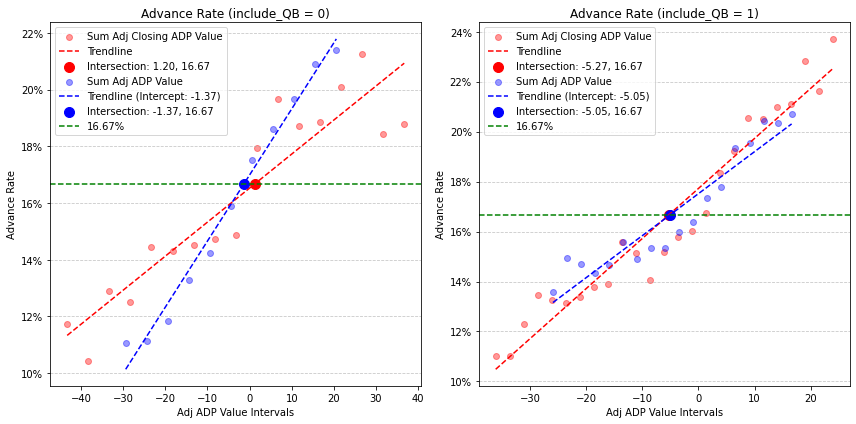

In [20]:
x_intersections_closing = {}
x_intersections_adp = {}

# Define the interval range for sum_adj_closing_adp_value and sum_adj_adp_value
interval_range_closing = [5, 2.5]
interval_range_adp = [5, 2.5]

# Set the minimum bin count
min_bin_count = [500, 2000]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Loop through include_QB = 0 and include_QB = 1
for include_qb, ax in zip([0, 1], axs.flatten()):
    # Filter the dataframe for the specific include_QB group
    filtered_df = stacks_df[stacks_df['include_QB'] == include_qb]
    min_value_closing = filtered_df['sum_adj_closing_adp_value'].min()
    max_value_closing = filtered_df['sum_adj_closing_adp_value'].max()

    # Create bins with a defined interval range for sum_adj_closing_adp_value
    bins_closing = pd.interval_range(start=min_value_closing, end=max_value_closing, freq=interval_range_closing[include_qb])

    # Calculate the percentage of rows with qtr_team = 1 for each bin of sum_adj_closing_adp_value
    result_df_closing = filtered_df.groupby(pd.cut(filtered_df['sum_adj_closing_adp_value'], bins=bins_closing))['qtr_team'].mean() * 100

    # Calculate the count for each bin
    bin_counts_closing = filtered_df.groupby(pd.cut(filtered_df['sum_adj_closing_adp_value'], bins=bins_closing)).size()

    # Filter out bins with a count below the minimum bin count
    valid_bins_closing = bin_counts_closing[bin_counts_closing >= min_bin_count[include_qb]]
    result_df_closing = result_df_closing.loc[result_df_closing.index.isin(valid_bins_closing.index)]

    bin_midpoints_closing = [(interval.left + interval.right) / 2 for interval in result_df_closing.index]
    ax.scatter(bin_midpoints_closing, result_df_closing.values, alpha=0.4, label='Sum Adj Closing ADP Value', color='red')

    # Calculate the trendline coefficients using numpy.polyfit
    z_closing = np.polyfit(bin_midpoints_closing, result_df_closing.values, 1)
    p_closing = np.poly1d(z_closing)

    # Calculate the intercept point with the trendline and the horizontal line at y = 16.67
    intercept_x_closing = (16.67 - z_closing[1]) / z_closing[0]
    intercept_y_closing = p_closing(intercept_x_closing)

    ax.plot(bin_midpoints_closing, p_closing(bin_midpoints_closing), 'r--', label=f'Trendline')
    ax.scatter(intercept_x_closing, intercept_y_closing, color='red', marker='o', s=100, label=f'Intersection: {intercept_x_closing:.2f}, {intercept_y_closing:.2f}')

    min_value_adp = filtered_df['sum_adj_adp_value'].min()
    max_value_adp = filtered_df['sum_adj_adp_value'].max()

    bins_adp = pd.interval_range(start=min_value_adp, end=max_value_adp, freq=interval_range_adp[include_qb])
    result_df_adp = filtered_df.groupby(pd.cut(filtered_df['sum_adj_adp_value'], bins=bins_adp))['qtr_team'].mean() * 100
    bin_counts_adp = filtered_df.groupby(pd.cut(filtered_df['sum_adj_adp_value'], bins=bins_adp)).size()
    valid_bins_adp = bin_counts_adp[bin_counts_adp >= min_bin_count[include_qb]]
    result_df_adp = result_df_adp.loc[result_df_adp.index.isin(valid_bins_adp.index)]

    bin_midpoints_adp = [(interval.left + interval.right) / 2 for interval in result_df_adp.index]
    ax.scatter(bin_midpoints_adp, result_df_adp.values, alpha=0.4, label='Sum Adj ADP Value', color='blue')

    # Calculate the trendline coefficients using numpy.polyfit for sum_adj_adp_value
    z_adp = np.polyfit(bin_midpoints_adp, result_df_adp.values, 1)
    p_adp = np.poly1d(z_adp)

    # Calculate the intercept point with the trendline and the horizontal line at y = 16.67 for sum_adj_adp_value
    intercept_x_adp = (16.67 - z_adp[1]) / z_adp[0]
    intercept_y_adp = p_adp(intercept_x_adp)
    
    x_intersections_closing[include_qb] = intercept_x_closing
    x_intersections_adp[include_qb] = intercept_x_adp

    ax.plot(bin_midpoints_adp, p_adp(bin_midpoints_adp), 'b--', label=f'Trendline (Intercept: {intercept_x_adp:.2f})')
    ax.scatter(intercept_x_adp, intercept_y_adp, color='blue', marker='o', s=100, label=f'Intersection: {intercept_x_adp:.2f}, {intercept_y_adp:.2f}')

    ax.axhline(y=16.67, color='green', linestyle='--', label='16.67%')

    ax.set_xlabel('Adj ADP Value Intervals')
    ax.set_ylabel('Advance Rate')
    ax.set_title(f'Advance Rate (include_QB = {include_qb})')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()

def percentage_formatter(x, pos):
    return f'{x:.0f}%'
for ax in axs.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.tight_layout()
plt.show()


Despite not seeing that much of a difference in overall advance rate, the figure above shows a clear advantage in having the QB. Whether you look at total closing line ADP value or total ADP value, both trendlines cross the expected advanced rate with lower ADP values than without the QB. Having the QB in your stack seems to raise the floor of the ADP of your stack and requires less ADP value.

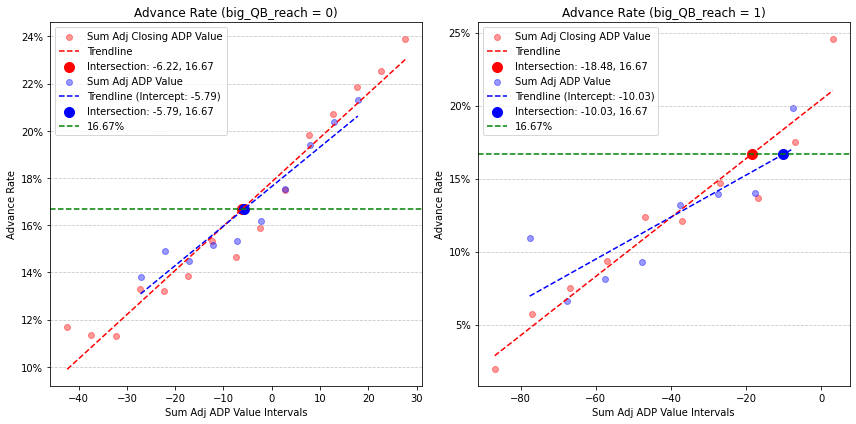

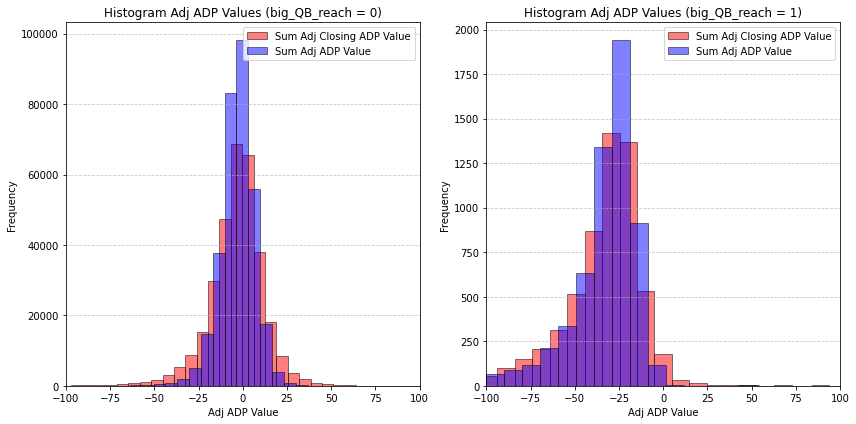

In [21]:
x_intersections_closing = {}
x_intersections_adp = {}

# Define the interval range for sum_adj_closing_adp_value and sum_adj_adp_value
interval_range_closing = [5, 10]
interval_range_adp = [5, 10]

# Set the minimum bin count
min_bin_count = [2000, 100]

filtered_df = stacks_df[stacks_df['include_QB'] == 1]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Loop through big_QB_reach = 0 and big_QB_reach = 1
for big_qb_reach, ax in zip([0, 1], axs.flatten()):
    # Filter the dataframe for the specific big_QB_reach group
    filtered_df_qb = filtered_df[filtered_df['big_QB_reach'] == big_qb_reach]
    min_value_closing = filtered_df_qb['sum_adj_closing_adp_value'].min()
    max_value_closing = filtered_df_qb['sum_adj_closing_adp_value'].max()

    # Create bins with a defined interval range for sum_adj_closing_adp_value
    bins_closing = pd.interval_range(start=min_value_closing, end=max_value_closing, freq=interval_range_closing[big_qb_reach])

    # Calculate the percentage of rows with qtr_team = 1 for each bin of sum_adj_closing_adp_value
    result_df_closing = filtered_df_qb.groupby(pd.cut(filtered_df_qb['sum_adj_closing_adp_value'], bins=bins_closing))['qtr_team'].mean() * 100

    # Calculate the count for each bin
    bin_counts_closing = filtered_df_qb.groupby(pd.cut(filtered_df_qb['sum_adj_closing_adp_value'], bins=bins_closing)).size()

    # Filter out bins with a count below the minimum bin count
    valid_bins_closing = bin_counts_closing[bin_counts_closing >= min_bin_count[big_qb_reach]]
    result_df_closing = result_df_closing.loc[result_df_closing.index.isin(valid_bins_closing.index)]

    bin_midpoints_closing = [(interval.left + interval.right) / 2 for interval in result_df_closing.index]
    ax.scatter(bin_midpoints_closing, result_df_closing.values, alpha=0.4, label='Sum Adj Closing ADP Value', color='red')

    # Calculate the trendline coefficients using numpy.polyfit
    z_closing = np.polyfit(bin_midpoints_closing, result_df_closing.values, 1)
    p_closing = np.poly1d(z_closing)

    # Calculate the intercept point with the trendline and the horizontal line at y = 16.67
    intercept_x_closing = (16.67 - z_closing[1]) / z_closing[0]
    intercept_y_closing = p_closing(intercept_x_closing)

    ax.plot(bin_midpoints_closing, p_closing(bin_midpoints_closing), 'r--', label=f'Trendline')
    ax.scatter(intercept_x_closing, intercept_y_closing, color='red', marker='o', s=100, label=f'Intersection: {intercept_x_closing:.2f}, {intercept_y_closing:.2f}')

    min_value_adp = filtered_df_qb['sum_adj_adp_value'].min()
    max_value_adp = filtered_df_qb['sum_adj_adp_value'].max()

    bins_adp = pd.interval_range(start=min_value_adp, end=max_value_adp, freq=interval_range_adp[big_qb_reach])
    result_df_adp = filtered_df_qb.groupby(pd.cut(filtered_df_qb['sum_adj_adp_value'], bins=bins_adp))['qtr_team'].mean() * 100
    bin_counts_adp = filtered_df_qb.groupby(pd.cut(filtered_df_qb['sum_adj_adp_value'], bins=bins_adp)).size()
    valid_bins_adp = bin_counts_adp[bin_counts_adp >= min_bin_count[big_qb_reach]]
    result_df_adp = result_df_adp.loc[result_df_adp.index.isin(valid_bins_adp.index)]

    bin_midpoints_adp = [(interval.left + interval.right) / 2 for interval in result_df_adp.index]
    ax.scatter(bin_midpoints_adp, result_df_adp.values, alpha=0.4, label='Sum Adj ADP Value', color='blue')

    # Calculate the trendline coefficients using numpy.polyfit for sum_adj_adp_value
    z_adp = np.polyfit(bin_midpoints_adp, result_df_adp.values, 1)
    p_adp = np.poly1d(z_adp)

    # Calculate the intercept point with the trendline and the horizontal line at y = 16.67 for sum_adj_adp_value
    intercept_x_adp = (16.67 - z_adp[1]) / z_adp[0]
    intercept_y_adp = p_adp(intercept_x_adp)
    
    x_intersections_closing[big_qb_reach] = intercept_x_closing
    x_intersections_adp[big_qb_reach] = intercept_x_adp

    ax.plot(bin_midpoints_adp, p_adp(bin_midpoints_adp), 'b--', label=f'Trendline (Intercept: {intercept_x_adp:.2f})')
    ax.scatter(intercept_x_adp, intercept_y_adp, color='blue', marker='o', s=100, label=f'Intersection: {intercept_x_adp:.2f}, {intercept_y_adp:.2f}')

    # Plot the horizontal line at y = 16.67
    ax.axhline(y=16.67, color='green', linestyle='--', label='16.67%')

    ax.set_xlabel('Sum Adj ADP Value Intervals')
    ax.set_ylabel('Advance Rate')
    ax.set_title(f'Advance Rate (big_QB_reach = {big_qb_reach})')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()

def percentage_formatter(x, pos):
    return f'{x:.0f}%'
for ax in axs.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.tight_layout()
plt.show()

# Filter the DataFrame to include only rows where include_QB is equal to 1 and big_QB_reach is equal to 0
filtered_df_include_qb = stacks_df[(stacks_df['include_QB'] == 1) & (stacks_df['big_QB_reach'] == 0)]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(filtered_df_include_qb['sum_adj_closing_adp_value'], bins=100, edgecolor='black', color='red', alpha=0.5, label='Sum Adj Closing ADP Value')
axs[0].hist(filtered_df_include_qb['sum_adj_adp_value'], bins=100, edgecolor='black', color='blue', alpha=0.5, label='Sum Adj ADP Value')

axs[0].set_xlabel('Adj ADP Value')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram Adj ADP Values (big_QB_reach = 0)')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].legend()

axs[0].set_xlim(-100, 100)

# Filter the DataFrame to include only rows where big_QB_reach is equal to 1
filtered_df_big_qb_reach = stacks_df[stacks_df['big_QB_reach'] == 1]

axs[1].hist(filtered_df_big_qb_reach['sum_adj_closing_adp_value'], bins=50, edgecolor='black', color='red', alpha=0.5, label='Sum Adj Closing ADP Value')
axs[1].hist(filtered_df_big_qb_reach['sum_adj_adp_value'], bins=50, edgecolor='black', color='blue', alpha=0.5, label='Sum Adj ADP Value')

axs[1].set_xlabel('Adj ADP Value')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram Adj ADP Values (big_QB_reach = 1)')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].legend()

# Set x-axis limits for the second subplot
axs[1].set_xlim(-100, 100)

plt.tight_layout()
plt.show()

If having your QB matters for creating better stacks, how much should we reach for them? I defined a big QB reach as any QB pick where the adjusted pick value was >= 15 than the adjusted ADP value. That is about a round in the early to mid-rounds and a round and a half to larger in the late rounds. What we see is surprising. 

Without the big QB reach the expected advance rate intersection is about the same as the intersection when the stack includes the QB. However, when there was a big QB reach the intersection happens even with an even more negative total ADP value. What this means is that reaching for your QB of your stack really doesn't hurt your advance rate all that much. 

Keep in mind though there were only about 6000 teams that had a big QB reach, and almost all of them resulted in negative total ADP values. We don't really know how teams performed if they got to zero or positive total ADP value but also reached for the QB. 

In [22]:
average_points_by_big_QB_reach = {}

for big_QB_reach in [0,1]:
    # Filter the dataframe for big_QB_reach where sum_adj_adp_value is greater than or equal to the x-intersection value
    filtered_df_intersection = stacks_df[
        (stacks_df['include_QB'] == 1) &
        (stacks_df['big_QB_reach'] == big_QB_reach) &
        (stacks_df['sum_adj_adp_value'] >= x_intersections_adp[big_QB_reach]) &
        (stacks_df['sum_adj_closing_adp_value'] >= x_intersections_closing[big_QB_reach])
    ]

    # Calculate the average qtr_roster_points, semi_roster_points, and finals_roster_points
    average_qtr_points_intersection = filtered_df_intersection['qtr_roster_points'].mean()
    average_semi_points_intersection = filtered_df_intersection['semi_roster_points'].mean()
    average_finals_points_intersection = filtered_df_intersection['finals_roster_points'].mean()

    # Filter the dataframe for big_QB_reach where sum_adj_adp_value is NOT greater than or equal to the x-intersection value
    filtered_df_no_intersection = stacks_df[
        (stacks_df['include_QB'] == 1) &
        (stacks_df['big_QB_reach'] == big_QB_reach) &
        (stacks_df['sum_adj_adp_value'] < x_intersections_adp[big_QB_reach]) &
        (stacks_df['sum_adj_closing_adp_value'] < x_intersections_closing[big_QB_reach])
    ]

    # Calculate the average qtr_roster_points, semi_roster_points, and finals_roster_points
    average_qtr_points_no_intersection = filtered_df_no_intersection['qtr_roster_points'].mean()
    average_semi_points_no_intersection = filtered_df_no_intersection['semi_roster_points'].mean()
    average_finals_points_no_intersection = filtered_df_no_intersection['finals_roster_points'].mean()

    average_points_by_big_QB_reach[big_QB_reach] = {
        'average_qtr_points_intersection': average_qtr_points_intersection,
        'average_semi_points_intersection': average_semi_points_intersection,
        'average_finals_points_intersection': average_finals_points_intersection,
        'average_qtr_points_no_intersection': average_qtr_points_no_intersection,
        'average_semi_points_no_intersection': average_semi_points_no_intersection,
        'average_finals_points_no_intersection': average_finals_points_no_intersection
    }
table_data = []
    
for big_QB_reach, points in average_points_by_big_QB_reach.items():
    table_data.append({
        'Includes Big QB Reach': big_QB_reach,
        'Avg Qtr Points (With Intersection)': round(points['average_qtr_points_intersection'], 2),
        'Avg Qtr Points (Without Intersection)': round(points['average_qtr_points_no_intersection'], 2),
        'Avg Semi Points (With Intersection)': round(points['average_semi_points_intersection'], 2),
        'Avg Semi Points (Without Intersection)': round(points['average_semi_points_no_intersection'], 2),
        'Avg Finals Points (With Intersection)': round(points['average_finals_points_intersection'], 2),
        'Avg Finals Points (Without Intersection)': round(points['average_finals_points_no_intersection'], 2)
    })

table_df = pd.DataFrame(table_data)
table_df

Includes Big QB Reach  Avg Qtr Points (With Intersection)  \
0                      0                              127.51   
1                      1                              128.35   

   Avg Qtr Points (Without Intersection)  Avg Semi Points (With Intersection)  \
0                                 126.41                               122.64   
1                                 125.91                               131.66   

   Avg Semi Points (Without Intersection)  \
0                                  120.39   
1                                  118.49   

   Avg Finals Points (With Intersection)  \
0                                 105.92   
1                                    NaN   

   Avg Finals Points (Without Intersection)  
0                                     98.78  
1                                     95.37

When examining the playoff weeks, we don't see much of a difference whether there was a big QB reach or not. Especially for big QB reach teams that crossed the ADP value intersections, we see them perform even better on average than teams that did not reach for the QB. 

## Stack Draft Cost

Next, we will examine how where you draft your stacks affects team performance. Particularly early stack and late stack pieces

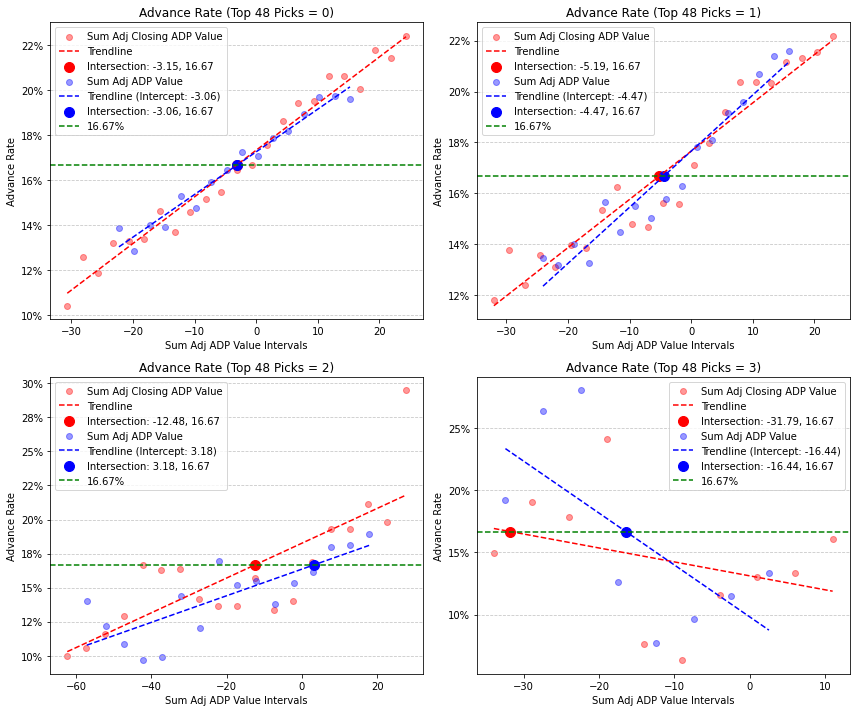

In [23]:
x_intersections_closing = {}
x_intersections_adp = {}

# Define the interval range for sum_adj_closing_adp_value and sum_adj_adp_value
interval_range_closing = [2.5, 2.5, 5, 5]
interval_range_adp = [2.5, 2.5, 5, 5]

# Set the minimum bin count
min_bin_count = [1500, 1500, 100, 100]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Loop through sum_48_picks = 0, 1, 2, 3
for sum_48_picks, ax in zip([0, 1, 2, 3], axs.flatten()):
    filtered_df = stacks_df[stacks_df['sum_48_picks'] == sum_48_picks]
    min_value_closing = filtered_df['sum_adj_closing_adp_value'].min()
    max_value_closing = filtered_df['sum_adj_closing_adp_value'].max()

    # Create bins with a defined interval range for sum_adj_closing_adp_value
    bins_closing = pd.interval_range(start=min_value_closing, end=max_value_closing, freq=interval_range_closing[sum_48_picks])

    # Calculate the percentage of rows with qtr_team = 1 for each bin of sum_adj_closing_adp_value
    result_df_closing = filtered_df.groupby(pd.cut(filtered_df['sum_adj_closing_adp_value'], bins=bins_closing))['qtr_team'].mean() * 100

    # Calculate the count for each bin
    bin_counts_closing = filtered_df.groupby(pd.cut(filtered_df['sum_adj_closing_adp_value'], bins=bins_closing)).size()

    # Filter out bins with a count below the minimum bin count
    valid_bins_closing = bin_counts_closing[bin_counts_closing >= min_bin_count[sum_48_picks]]
    result_df_closing = result_df_closing.loc[result_df_closing.index.isin(valid_bins_closing.index)]

    bin_midpoints_closing = [(interval.left + interval.right) / 2 for interval in result_df_closing.index]
    ax.scatter(bin_midpoints_closing, result_df_closing.values, alpha=0.4, label='Sum Adj Closing ADP Value', color='red')

    # Calculate the trendline coefficients using numpy.polyfit
    z_closing = np.polyfit(bin_midpoints_closing, result_df_closing.values, 1)
    p_closing = np.poly1d(z_closing)

    # Calculate the intercept point with the trendline and the horizontal line at y = 16.67
    intercept_x_closing = (16.67 - z_closing[1]) / z_closing[0]
    intercept_y_closing = p_closing(intercept_x_closing)

    ax.plot(bin_midpoints_closing, p_closing(bin_midpoints_closing), 'r--', label=f'Trendline')
    ax.scatter(intercept_x_closing, intercept_y_closing, color='red', marker='o', s=100, label=f'Intersection: {intercept_x_closing:.2f}, {intercept_y_closing:.2f}')

    min_value_adp = filtered_df['sum_adj_adp_value'].min()
    max_value_adp = filtered_df['sum_adj_adp_value'].max()

    bins_adp = pd.interval_range(start=min_value_adp, end=max_value_adp, freq=interval_range_adp[sum_48_picks])
    result_df_adp = filtered_df.groupby(pd.cut(filtered_df['sum_adj_adp_value'], bins=bins_adp))['qtr_team'].mean() * 100
    bin_counts_adp = filtered_df.groupby(pd.cut(filtered_df['sum_adj_adp_value'], bins=bins_adp)).size()
    valid_bins_adp = bin_counts_adp[bin_counts_adp >= min_bin_count[sum_48_picks]]
    result_df_adp = result_df_adp.loc[result_df_adp.index.isin(valid_bins_adp.index)]

    bin_midpoints_adp = [(interval.left + interval.right) / 2 for interval in result_df_adp.index]
    ax.scatter(bin_midpoints_adp, result_df_adp.values, alpha=0.4, label='Sum Adj ADP Value', color='blue')

    # Calculate the trendline coefficients using numpy.polyfit for sum_adj_adp_value
    z_adp = np.polyfit(bin_midpoints_adp, result_df_adp.values, 1)
    p_adp = np.poly1d(z_adp)

    # Calculate the intercept point with the trendline and the horizontal line at y = 16.67 for sum_adj_adp_value
    intercept_x_adp = (16.67 - z_adp[1]) / z_adp[0]
    intercept_y_adp = p_adp(intercept_x_adp)
    
    x_intersections_closing[sum_48_picks] = intercept_x_closing
    x_intersections_adp[sum_48_picks] = intercept_x_adp

    ax.plot(bin_midpoints_adp, p_adp(bin_midpoints_adp), 'b--', label=f'Trendline (Intercept: {intercept_x_adp:.2f})')
    ax.scatter(intercept_x_adp, intercept_y_adp, color='blue', marker='o', s=100, label=f'Intersection: {intercept_x_adp:.2f}, {intercept_y_adp:.2f}')

    # Plot the horizontal line at y = 16.67
    ax.axhline(y=16.67, color='green', linestyle='--', label='16.67%')

    ax.set_xlabel('Sum Adj ADP Value Intervals')
    ax.set_ylabel('Advance Rate')
    ax.set_title(f'Advance Rate (Top 48 Picks = {sum_48_picks})')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()

# Function to format y-axis tick labels as percentages
def percentage_formatter(x, pos):
    return f'{x:.0f}%'

# Apply the formatter to all y-axes
for ax in axs.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.tight_layout()
plt.show()


Having two top 48 picks does show some correlation to advance rate with higher ADP value but is not as correlative with 0 or 1. Three top 48 picks shows no correlation between ADP value and advance rate.

If you want to stack more than 1 top 48 pick don't worry about ADP. If you hit on the stack, it won't matter where you drafted them.

In [24]:
# Calculate the average qtr_roster_points, semi_roster_points, and finals_roster_points
average_points_by_sum_48_picks = {}

for sum_48_picks in [0, 1, 2, 3]:
    # Filter the dataframe for num_players where sum_adj_adp_value is greater than or equal to the x-intersection value
    filtered_df_intersection = stacks_df[
        (stacks_df['sum_48_picks'] == sum_48_picks) &
        (stacks_df['sum_adj_adp_value'] >= x_intersections_adp[sum_48_picks]) &
        (stacks_df['sum_adj_closing_adp_value'] >= x_intersections_closing[sum_48_picks])
    ]

    # Calculate the average qtr_roster_points, semi_roster_points, and finals_roster_points
    average_qtr_points_intersection = filtered_df_intersection['qtr_roster_points'].mean()
    average_semi_points_intersection = filtered_df_intersection['semi_roster_points'].mean()
    average_finals_points_intersection = filtered_df_intersection['finals_roster_points'].mean()

    # Filter the dataframe for num_players where sum_adj_adp_value is NOT greater than or equal to the x-intersection value
    filtered_df_no_intersection = stacks_df[
        (stacks_df['sum_48_picks'] == sum_48_picks) &
        (stacks_df['sum_adj_adp_value'] < x_intersections_adp[sum_48_picks]) &
        (stacks_df['sum_adj_closing_adp_value'] < x_intersections_closing[sum_48_picks])
    ]

    # Calculate the average qtr_roster_points, semi_roster_points, and finals_roster_points
    average_qtr_points_no_intersection = filtered_df_no_intersection['qtr_roster_points'].mean()
    average_semi_points_no_intersection = filtered_df_no_intersection['semi_roster_points'].mean()
    average_finals_points_no_intersection = filtered_df_no_intersection['finals_roster_points'].mean()

    average_points_by_sum_48_picks[sum_48_picks] = {
        'average_qtr_points_intersection': average_qtr_points_intersection,
        'average_semi_points_intersection': average_semi_points_intersection,
        'average_finals_points_intersection': average_finals_points_intersection,
        'average_qtr_points_no_intersection': average_qtr_points_no_intersection,
        'average_semi_points_no_intersection': average_semi_points_no_intersection,
        'average_finals_points_no_intersection': average_finals_points_no_intersection
    }

table_data = []
for sum_48_picks, points in average_points_by_sum_48_picks.items():
    table_data.append({
        'Number of Top 48 Players': sum_48_picks,
        'Avg Qtr Points (With Intersection)': round(points['average_qtr_points_intersection'], 2),
        'Avg Qtr Points (Without Intersection)': round(points['average_qtr_points_no_intersection'], 2),
        'Avg Semi Points (With Intersection)': round(points['average_semi_points_intersection'], 2),
        'Avg Semi Points (Without Intersection)': round(points['average_semi_points_no_intersection'], 2),
        'Avg Finals Points (With Intersection)': round(points['average_finals_points_intersection'], 2),
        'Avg Finals Points (Without Intersection)': round(points['average_finals_points_no_intersection'], 2)
    })

table_df = pd.DataFrame(table_data)
table_df

Number of Top 48 Players  Avg Qtr Points (With Intersection)  \
0                         0                              126.74   
1                         1                              128.27   
2                         2                              125.23   
3                         3                              112.29   

   Avg Qtr Points (Without Intersection)  Avg Semi Points (With Intersection)  \
0                                 124.87                               122.61   
1                                 127.20                               122.65   
2                                 123.50                               124.30   
3                                 118.41                               110.07   

   Avg Semi Points (Without Intersection)  \
0                                  121.65   
1                                  120.30   
2                                  119.33   
3                                  100.96   

   Avg Finals Points (With Intersection)  \
0                                 105.76   
1                                 106.72   
2                                  95.47   
3                                    NaN   

   Avg Finals Points (Without Intersection)  
0                                     98.90  
1                                    106.48  
2                                     88.47  
3                                       NaN

In the playoff weeks we see more of the same, with having ADP value with 0 or 1 top 48 picks in the stacks performing better on average, but it also seems to help to get ADP value when you get to 2 early picks in your stack. 3 stack picks in the top 48 shows no benefit to getting ADP value in the playoff weeks.

If you want to stack more than 2 early picks don't worry about where you draft them. Even if you get ADP value there is no trend that those teams will perform better than the teams that had to reach for the stack in the playoffs.

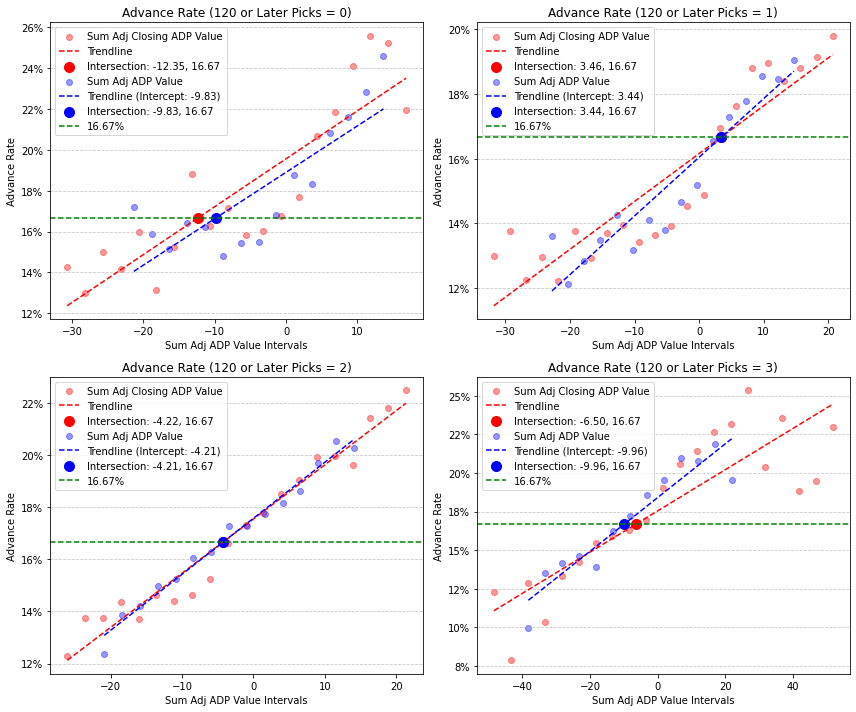

In [25]:
x_intersections_closing = {}
x_intersections_adp = {}

# Define the interval range for sum_adj_closing_adp_value and sum_adj_adp_value
interval_range_closing = [2.5, 2.5, 2.5, 5]
interval_range_adp = [2.5, 2.5, 2.5, 5]

# Set the minimum bin count
min_bin_count = [1000, 1500, 1500, 100]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Loop through sum_120_picks = 0, 1, 2, 3
for sum_120_picks, ax in zip([0, 1, 2, 3], axs.flatten()):
    filtered_df = stacks_df[stacks_df['sum_120_picks'] == sum_120_picks]
    min_value_closing = filtered_df['sum_adj_closing_adp_value'].min()
    max_value_closing = filtered_df['sum_adj_closing_adp_value'].max()

    # Create bins with a defined interval range for sum_adj_closing_adp_value
    bins_closing = pd.interval_range(start=min_value_closing, end=max_value_closing, freq=interval_range_closing[sum_120_picks])

    # Calculate the percentage of rows with qtr_team = 1 for each bin of sum_adj_closing_adp_value
    result_df_closing = filtered_df.groupby(pd.cut(filtered_df['sum_adj_closing_adp_value'], bins=bins_closing))['qtr_team'].mean() * 100

    # Calculate the count for each bin
    bin_counts_closing = filtered_df.groupby(pd.cut(filtered_df['sum_adj_closing_adp_value'], bins=bins_closing)).size()

    # Filter out bins with a count below the minimum bin count
    valid_bins_closing = bin_counts_closing[bin_counts_closing >= min_bin_count[sum_120_picks]]
    result_df_closing = result_df_closing.loc[result_df_closing.index.isin(valid_bins_closing.index)]

    bin_midpoints_closing = [(interval.left + interval.right) / 2 for interval in result_df_closing.index]
    ax.scatter(bin_midpoints_closing, result_df_closing.values, alpha=0.4, label='Sum Adj Closing ADP Value', color='red')

    # Calculate the trendline coefficients using numpy.polyfit
    z_closing = np.polyfit(bin_midpoints_closing, result_df_closing.values, 1)
    p_closing = np.poly1d(z_closing)

    # Calculate the intercept point with the trendline and the horizontal line at y = 16.67
    intercept_x_closing = (16.67 - z_closing[1]) / z_closing[0]
    intercept_y_closing = p_closing(intercept_x_closing)

    ax.plot(bin_midpoints_closing, p_closing(bin_midpoints_closing), 'r--', label=f'Trendline')
    ax.scatter(intercept_x_closing, intercept_y_closing, color='red', marker='o', s=100, label=f'Intersection: {intercept_x_closing:.2f}, {intercept_y_closing:.2f}')

    min_value_adp = filtered_df['sum_adj_adp_value'].min()
    max_value_adp = filtered_df['sum_adj_adp_value'].max()

    bins_adp = pd.interval_range(start=min_value_adp, end=max_value_adp, freq=interval_range_adp[sum_120_picks])
    result_df_adp = filtered_df.groupby(pd.cut(filtered_df['sum_adj_adp_value'], bins=bins_adp))['qtr_team'].mean() * 100
    bin_counts_adp = filtered_df.groupby(pd.cut(filtered_df['sum_adj_adp_value'], bins=bins_adp)).size()
    valid_bins_adp = bin_counts_adp[bin_counts_adp >= min_bin_count[sum_120_picks]]
    result_df_adp = result_df_adp.loc[result_df_adp.index.isin(valid_bins_adp.index)]

    bin_midpoints_adp = [(interval.left + interval.right) / 2 for interval in result_df_adp.index]
    ax.scatter(bin_midpoints_adp, result_df_adp.values, alpha=0.4, label='Sum Adj ADP Value', color='blue')

    # Calculate the trendline coefficients using numpy.polyfit for sum_adj_adp_value
    z_adp = np.polyfit(bin_midpoints_adp, result_df_adp.values, 1)
    p_adp = np.poly1d(z_adp)

    # Calculate the intercept point with the trendline and the horizontal line at y = 16.67 for sum_adj_adp_value
    intercept_x_adp = (16.67 - z_adp[1]) / z_adp[0]
    intercept_y_adp = p_adp(intercept_x_adp)
    
    x_intersections_closing[sum_120_picks] = intercept_x_closing
    x_intersections_adp[sum_120_picks] = intercept_x_adp

    ax.plot(bin_midpoints_adp, p_adp(bin_midpoints_adp), 'b--', label=f'Trendline (Intercept: {intercept_x_adp:.2f})')
    ax.scatter(intercept_x_adp, intercept_y_adp, color='blue', marker='o', s=100, label=f'Intersection: {intercept_x_adp:.2f}, {intercept_y_adp:.2f}')

    # Plot the horizontal line at y = 16.67
    ax.axhline(y=16.67, color='green', linestyle='--', label='16.67%')

    ax.set_xlabel('Sum Adj ADP Value Intervals')
    ax.set_ylabel('Advance Rate')
    ax.set_title(f'Advance Rate (120 or Later Picks = {sum_120_picks})')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()

# Function to format y-axis tick labels as percentages
def percentage_formatter(x, pos):
    return f'{x:.0f}%'

# Apply the formatter to all y-axes
for ax in axs.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.tight_layout()
plt.show()


When looking at ADP values on stacks that contain later picks, we see that as you increase your late round stack pieces the less you must worry about getting positive ADP value. Particularly, having two late round stack pieces shows the strongest correlation between advance rate and ADP value, but having 3, which could be the entire stack, reaches an expected advance rate at -9 total adjusted ADP value.

In [26]:
# Calculate the average qtr_roster_points, semi_roster_points, and finals_roster_points
average_points_by_sum_120_picks = {}

for sum_120_picks in [0, 1, 2, 3]:
    # Filter the dataframe for num_players where sum_adj_adp_value is greater than or equal to the x-intersection value
    filtered_df_intersection = stacks_df[
        (stacks_df['sum_120_picks'] == sum_120_picks) &
        (stacks_df['sum_adj_adp_value'] >= x_intersections_adp[sum_120_picks]) &
        (stacks_df['sum_adj_closing_adp_value'] >= x_intersections_closing[sum_120_picks])
    ]

    # Calculate the average qtr_roster_points, semi_roster_points, and finals_roster_points
    average_qtr_points_intersection = filtered_df_intersection['qtr_roster_points'].mean()
    average_semi_points_intersection = filtered_df_intersection['semi_roster_points'].mean()
    average_finals_points_intersection = filtered_df_intersection['finals_roster_points'].mean()

    # Filter the dataframe for num_players where sum_adj_adp_value is NOT greater than or equal to the x-intersection value
    filtered_df_no_intersection = stacks_df[
        (stacks_df['sum_120_picks'] == sum_120_picks) &
        (stacks_df['sum_adj_adp_value'] < x_intersections_adp[sum_120_picks]) &
        (stacks_df['sum_adj_closing_adp_value'] < x_intersections_closing[sum_120_picks])
    ]

    # Calculate the average qtr_roster_points, semi_roster_points, and finals_roster_points
    average_qtr_points_no_intersection = filtered_df_no_intersection['qtr_roster_points'].mean()
    average_semi_points_no_intersection = filtered_df_no_intersection['semi_roster_points'].mean()
    average_finals_points_no_intersection = filtered_df_no_intersection['finals_roster_points'].mean()

    average_points_by_sum_120_picks[sum_120_picks] = {
        'average_qtr_points_intersection': average_qtr_points_intersection,
        'average_semi_points_intersection': average_semi_points_intersection,
        'average_finals_points_intersection': average_finals_points_intersection,
        'average_qtr_points_no_intersection': average_qtr_points_no_intersection,
        'average_semi_points_no_intersection': average_semi_points_no_intersection,
        'average_finals_points_no_intersection': average_finals_points_no_intersection
    }

table_data = []
for sum_120_picks, points in average_points_by_sum_120_picks.items():
    table_data.append({
        'Number of Pick 120 or Later Players': sum_120_picks,
        'Avg Qtr Points (With Intersection)': round(points['average_qtr_points_intersection'], 2),
        'Avg Qtr Points (Without Intersection)': round(points['average_qtr_points_no_intersection'], 2),
        'Avg Semi Points (With Intersection)': round(points['average_semi_points_intersection'], 2),
        'Avg Semi Points (Without Intersection)': round(points['average_semi_points_no_intersection'], 2),
        'Avg Finals Points (With Intersection)': round(points['average_finals_points_intersection'], 2),
        'Avg Finals Points (Without Intersection)': round(points['average_finals_points_no_intersection'], 2)
    })

table_df = pd.DataFrame(table_data)
table_df

Number of Pick 120 or Later Players  Avg Qtr Points (With Intersection)  \
0                                    0                              126.96   
1                                    1                              126.98   
2                                    2                              127.12   
3                                    3                              127.90   

   Avg Qtr Points (Without Intersection)  Avg Semi Points (With Intersection)  \
0                                 126.04                               122.35   
1                                 125.49                               122.92   
2                                 125.81                               122.00   
3                                 126.81                               122.65   

   Avg Semi Points (Without Intersection)  \
0                                  121.11   
1                                  122.42   
2                                  119.17   
3                                  118.83   

   Avg Finals Points (With Intersection)  \
0                                 106.57   
1                                 109.15   
2                                 106.31   
3                                 106.87   

   Avg Finals Points (Without Intersection)  
0                                    102.45  
1                                    101.64  
2                                    102.70  
3                                     83.14

As more late stack pieces are used the difference in playoff performance becomes wider as more ADP value is reached. With 0 or 1 late round stack pieces the average points don't change much throughout the playoffs, but with 2 or 3 the semifinals and finals average points differ much more based on if they hit the expected advance rate intersection point.

The more late stack pieces utilized the more ADP value becomes beneficial.

## How ADP Value Affects Specific Player Stacks

Lastly, we are going to compare specific stacks against each other and see if it mattered if the stacks were made with ADP value or not.

In [27]:
# Group stacks_df by player_names
grouped_df = stacks_df.groupby('player_names')

# Calculate the percentage of teams with qtr_team = 1 in each group
percentage_qtr_team_1 = (grouped_df['qtr_team'].sum() / grouped_df['qtr_team'].count()) * 100

# Calculate the count of each group
group_counts = grouped_df.size()

result_df = pd.DataFrame({
    'count': group_counts,
    'qtr_team_1_percent': percentage_qtr_team_1
})

# Filter out groups with a count less than 750
result_df = result_df[result_df['count'] >= 750]
result_df = result_df.sort_values(by='qtr_team_1_percent', ascending=False)

# Extract player_names from the index of result_df and convert to a list
player_names_list = result_df.index.tolist()

In [28]:
player_names_set = set(player_names_list)

# Filter stacks_df to keep only rows where player_names is in the set of player_names_to_filter
filtered_stacks_df = stacks_df[stacks_df['player_names'].isin(player_names_list)]

# Custom function to filter groups based on quantile and calculate the average roster points
def filter_by_bottom_quantile(group, quantile):
    q = group['roster_points'].quantile(quantile)
    return group[group['roster_points'] < q]

def filter_by_top_quantile(group, quantile):
    q = group['roster_points'].quantile(quantile)  # Get the upper quantile
    return group[group['roster_points'] >= q]

# Calculate the bottom and top 10% of roster_points for each unique player_names
bottom_10_df = filtered_stacks_df.groupby('player_names', group_keys=False).apply(filter_by_bottom_quantile, quantile=0.10)
top_10_df = filtered_stacks_df.groupby('player_names', group_keys=False).apply(filter_by_top_quantile, quantile=0.90)

# Calculate the average roster points for each group
bottom_10_avg_points = bottom_10_df.groupby('player_names')['roster_points'].mean()
top_10_avg_points = top_10_df.groupby('player_names')['roster_points'].mean()

# Calculate the average sum_adj_adp_value for each group
bottom_10_avg_adp_value = bottom_10_df.groupby('player_names')['sum_adj_adp_value'].mean()
top_10_avg_adp_value = top_10_df.groupby('player_names')['sum_adj_adp_value'].mean()

# Calculate the average sum_adj_closing_adp_value for each group
bottom_10_avg_closing_adp_value = bottom_10_df.groupby('player_names')['sum_adj_closing_adp_value'].mean()
top_10_avg_closing_adp_value = top_10_df.groupby('player_names')['sum_adj_closing_adp_value'].mean()

reg_result_df = pd.DataFrame({
    'Bottom 10% Avg Roster Points': bottom_10_avg_points,
    'Top 10% Avg Roster Points': top_10_avg_points,
    'Bottom 10% Avg Adj ADP Value': bottom_10_avg_adp_value,
    'Top 10% Avg Adj ADP Value': top_10_avg_adp_value,
    'Bottom 10% Avg Adj Closing ADP Value': bottom_10_avg_closing_adp_value,
    'Top 10% Avg Adj Closing ADP Value': top_10_avg_closing_adp_value
})

In [29]:
# Filter stacks_df to keep only rows where player_names is in the set of player_names_to_filter
filtered_stacks_df = stacks_df[stacks_df['player_names'].isin(player_names_list)]

# Custom function to filter groups based on quantile and calculate the average roster points
def filter_by_bottom_quantile(group, quantile):
    q = group['qtr_roster_points'].quantile(quantile)
    return group[group['qtr_roster_points'] < q]

def filter_by_top_quantile(group, quantile):
    q = group['qtr_roster_points'].quantile(quantile)  # Get the upper quantile
    return group[group['qtr_roster_points'] >= q]

# Calculate the bottom and top 10% of roster_points for each unique player_names
bottom_10_df = filtered_stacks_df.groupby('player_names', group_keys=False).apply(filter_by_bottom_quantile, quantile=0.10)
top_10_df = filtered_stacks_df.groupby('player_names', group_keys=False).apply(filter_by_top_quantile, quantile=0.90)

# Calculate the average roster points for each group
bottom_10_avg_points = bottom_10_df.groupby('player_names')['qtr_roster_points'].mean()
top_10_avg_points = top_10_df.groupby('player_names')['qtr_roster_points'].mean()

# Calculate the average sum_adj_adp_value for each group
bottom_10_avg_adp_value = bottom_10_df.groupby('player_names')['sum_adj_adp_value'].mean()
top_10_avg_adp_value = top_10_df.groupby('player_names')['sum_adj_adp_value'].mean()

# Calculate the average sum_adj_closing_adp_value for each group
bottom_10_avg_closing_adp_value = bottom_10_df.groupby('player_names')['sum_adj_closing_adp_value'].mean()
top_10_avg_closing_adp_value = top_10_df.groupby('player_names')['sum_adj_closing_adp_value'].mean()

qtr_result_df = pd.DataFrame({
    'Bottom 10% Avg Roster Points': bottom_10_avg_points,
    'Top 10% Avg Roster Points': top_10_avg_points,
    'Bottom 10% Avg Adj ADP Value': bottom_10_avg_adp_value,
    'Top 10% Avg Adj ADP Value': top_10_avg_adp_value,
    'Bottom 10% Avg Adj Closing ADP Value': bottom_10_avg_closing_adp_value,
    'Top 10% Avg Adj Closing ADP Value': top_10_avg_closing_adp_value
})
qtr_result_df = qtr_result_df.add_prefix('Qtr ')

In [30]:
# Filter stacks_df to keep only rows where player_names is in the set of player_names_to_filter
filtered_stacks_df = stacks_df[stacks_df['player_names'].isin(player_names_list)]

# Custom function to filter groups based on quantile and calculate the average roster points
def filter_by_bottom_quantile(group, quantile):
    q = group['semi_roster_points'].quantile(quantile)
    return group[group['semi_roster_points'] < q]

def filter_by_top_quantile(group, quantile):
    q = group['semi_roster_points'].quantile(quantile)  # Get the upper quantile
    return group[group['semi_roster_points'] >= q]

# Calculate the bottom and top 10% of roster_points for each unique player_names
bottom_10_df = filtered_stacks_df.groupby('player_names', group_keys=False).apply(filter_by_bottom_quantile, quantile=0.10)
top_10_df = filtered_stacks_df.groupby('player_names', group_keys=False).apply(filter_by_top_quantile, quantile=0.90)

# Calculate the average roster points for each group
bottom_10_avg_points = bottom_10_df.groupby('player_names')['semi_roster_points'].mean()
top_10_avg_points = top_10_df.groupby('player_names')['semi_roster_points'].mean()

# Calculate the average sum_adj_adp_value for each group
bottom_10_avg_adp_value = bottom_10_df.groupby('player_names')['sum_adj_adp_value'].mean()
top_10_avg_adp_value = top_10_df.groupby('player_names')['sum_adj_adp_value'].mean()

# Calculate the average sum_adj_closing_adp_value for each group
bottom_10_avg_closing_adp_value = bottom_10_df.groupby('player_names')['sum_adj_closing_adp_value'].mean()
top_10_avg_closing_adp_value = top_10_df.groupby('player_names')['sum_adj_closing_adp_value'].mean()

semi_result_df = pd.DataFrame({
    'Bottom 10% Avg Roster Points': bottom_10_avg_points,
    'Top 10% Avg Roster Points': top_10_avg_points,
    'Bottom 10% Avg Adj ADP Value': bottom_10_avg_adp_value,
    'Top 10% Avg Adj ADP Value': top_10_avg_adp_value,
    'Bottom 10% Avg Adj Closing ADP Value': bottom_10_avg_closing_adp_value,
    'Top 10% Avg Adj Closing ADP Value': top_10_avg_closing_adp_value
})
semi_result_df = semi_result_df.add_prefix('Semi ')

In [31]:
# Filter stacks_df to keep only rows where player_names is in the set of player_names_to_filter
filtered_stacks_df = stacks_df[stacks_df['player_names'].isin(player_names_list)]

# Custom function to filter groups based on quantile and calculate the average roster points
def filter_by_bottom_quantile(group, quantile):
    q = group['finals_roster_points'].quantile(quantile)
    return group[group['finals_roster_points'] < q]

def filter_by_top_quantile(group, quantile):
    q = group['finals_roster_points'].quantile(quantile)  # Get the upper quantile
    return group[group['finals_roster_points'] >= q]

# Calculate the bottom and top 10% of roster_points for each unique player_names
bottom_10_df = filtered_stacks_df.groupby('player_names', group_keys=False).apply(filter_by_bottom_quantile, quantile=0.10)
top_10_df = filtered_stacks_df.groupby('player_names', group_keys=False).apply(filter_by_top_quantile, quantile=0.90)

# Calculate the average roster points for each group
bottom_10_avg_points = bottom_10_df.groupby('player_names')['finals_roster_points'].mean()
top_10_avg_points = top_10_df.groupby('player_names')['finals_roster_points'].mean()

# Calculate the average sum_adj_adp_value for each group
bottom_10_avg_adp_value = bottom_10_df.groupby('player_names')['sum_adj_adp_value'].mean()
top_10_avg_adp_value = top_10_df.groupby('player_names')['sum_adj_adp_value'].mean()

# Calculate the average sum_adj_closing_adp_value for each group
bottom_10_avg_closing_adp_value = bottom_10_df.groupby('player_names')['sum_adj_closing_adp_value'].mean()
top_10_avg_closing_adp_value = top_10_df.groupby('player_names')['sum_adj_closing_adp_value'].mean()

finals_result_df = pd.DataFrame({
    'Bottom 10% Avg Roster Points': bottom_10_avg_points,
    'Top 10% Avg Roster Points': top_10_avg_points,
    'Bottom 10% Avg Adj ADP Value': bottom_10_avg_adp_value,
    'Top 10% Avg Adj ADP Value': top_10_avg_adp_value,
    'Bottom 10% Avg Adj Closing ADP Value': bottom_10_avg_closing_adp_value,
    'Top 10% Avg Adj Closing ADP Value': top_10_avg_closing_adp_value
})
finals_result_df = finals_result_df.add_prefix('Finals ')

In [32]:
merged_df = reg_result_df.merge(qtr_result_df, on='player_names', how="left", suffixes=('_overall', '_qtr'))
merged_df = merged_df.merge(semi_result_df, on='player_names', how="left", suffixes=('_qtr', '_semi'))
merged_df = merged_df.merge(finals_result_df, on='player_names', how="left", suffixes=('_semi', '_finals'))

In [33]:
merged_df['Regular Season ADP Diff']=merged_df['Top 10% Avg Adj ADP Value']-merged_df['Bottom 10% Avg Adj ADP Value']
merged_df['QuaterFinals ADP Diff']=merged_df['Qtr Top 10% Avg Adj ADP Value']-merged_df['Qtr Bottom 10% Avg Adj ADP Value']
merged_df['SemiFinals ADP Diff']=merged_df['Semi Top 10% Avg Adj ADP Value']-merged_df['Semi Bottom 10% Avg Adj ADP Value']
merged_df['Finals ADP Diff']=merged_df['Finals Top 10% Avg Adj ADP Value']-merged_df['Finals Bottom 10% Avg Adj ADP Value']

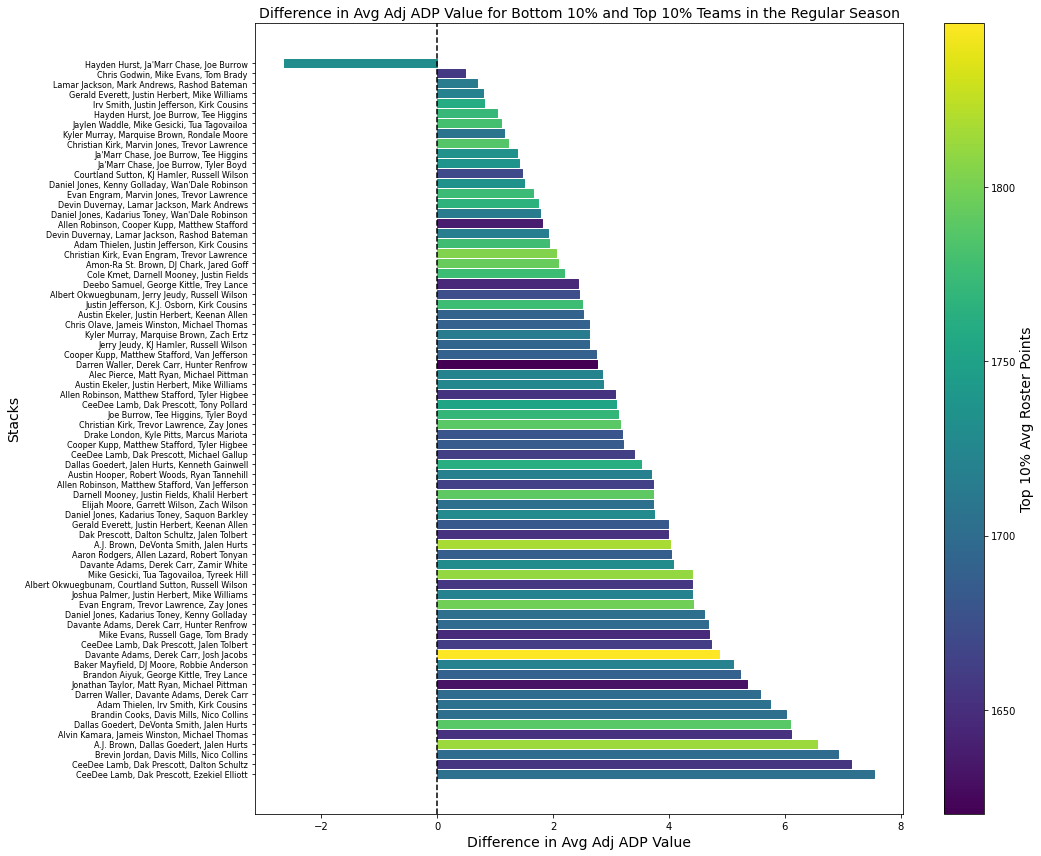

In [34]:
# Sort merged_df by 'Regular Season ADP Diff' in descending order
merged_df_sorted = merged_df.sort_values(by='Regular Season ADP Diff', ascending=False)

merged_df_sorted = merged_df_sorted.reset_index()
plt.figure(figsize=(15, 12))
bars = plt.barh(merged_df_sorted['player_names'], merged_df_sorted['Regular Season ADP Diff'])

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=merged_df_sorted['Top 10% Avg Roster Points'].min(),
                     vmax=merged_df_sorted['Top 10% Avg Roster Points'].max())
for bar, color in zip(bars, cmap(norm(merged_df_sorted['Top 10% Avg Roster Points']))):
    bar.set_color(color)

plt.title('Difference in Avg Adj ADP Value for Bottom 10% and Top 10% Teams in the Regular Season',fontsize=14)
plt.xlabel('Difference in Avg Adj ADP Value',fontsize=14)
plt.ylabel('Stacks',fontsize=14)

plt.axvline(x=0, color='black', linestyle='--')
plt.yticks(np.arange(len(merged_df_sorted)), merged_df_sorted['player_names'], fontsize=8)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Top 10% Avg Roster Points',fontsize=14)
plt.tight_layout()
plt.show()


Of all stacks that were drafted at least 750 times, only 1 did not have a positive difference between the top 10% of team's roster points average ADP value and bottom 10% of team's roster points average ADP value. This means that if on average you wanted a team that finished in the top 10% of regular season points with that stack you had to get more ADP value on that stack than other teams.

That being said, it is not a huge difference. Most stacks were within 0-5 points of average ADP value than the bottom 10%. One player in the stack falling to you can make that happen.

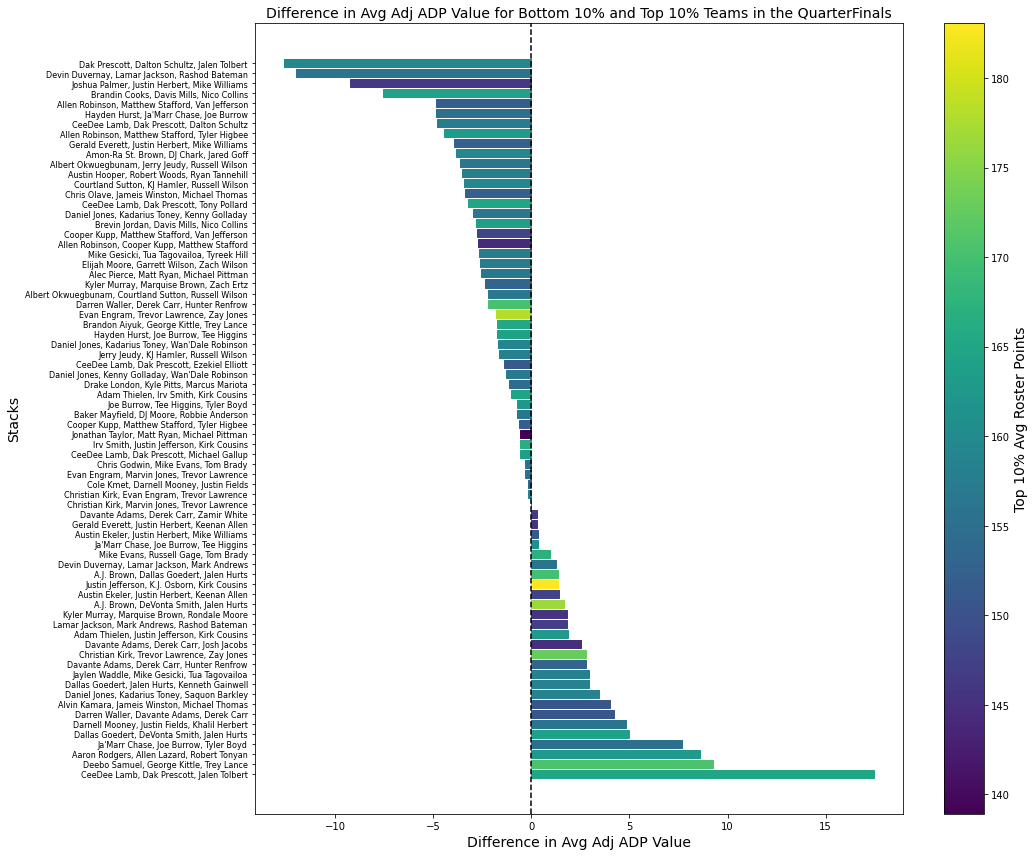

In [35]:
filtered_merged_df = merged_df.dropna(subset=['QuaterFinals ADP Diff'])
filtered_merged_df_sorted = filtered_merged_df.sort_values(by='QuaterFinals ADP Diff', ascending=False)
filtered_merged_df_sorted = filtered_merged_df_sorted.reset_index()
plt.figure(figsize=(15, 12))
bars = plt.barh(filtered_merged_df_sorted['player_names'], filtered_merged_df_sorted['QuaterFinals ADP Diff'])

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=filtered_merged_df_sorted['Qtr Top 10% Avg Roster Points'].min(),
                     vmax=filtered_merged_df_sorted['Qtr Top 10% Avg Roster Points'].max())
for bar, color in zip(bars, cmap(norm(filtered_merged_df_sorted['Qtr Top 10% Avg Roster Points']))):
    bar.set_color(color)

plt.title('Difference in Avg Adj ADP Value for Bottom 10% and Top 10% Teams in the QuarterFinals',fontsize=14)
plt.xlabel('Difference in Avg Adj ADP Value',fontsize=14)
plt.ylabel('Stacks',fontsize=14)

# Draw a vertical line at x = 0
plt.axvline(x=0, color='black', linestyle='--')

plt.yticks(np.arange(len(filtered_merged_df_sorted)), filtered_merged_df_sorted['player_names'], fontsize=8)

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Top 10% Avg Roster Points',fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


In the playoff weeks, ADP value did not matter to having a top 10% stack when compared to that same stack but in the bottom 10%. This means you shouldn't be unwilling to reach at times to add to your stack if you think it is necessary to add to it, but the color maps for both the quarterfinals and semifinals show many of the best stacks overall did come from stacks that leaned towards having a positive average ADP value difference between top and bottom 10% teams.

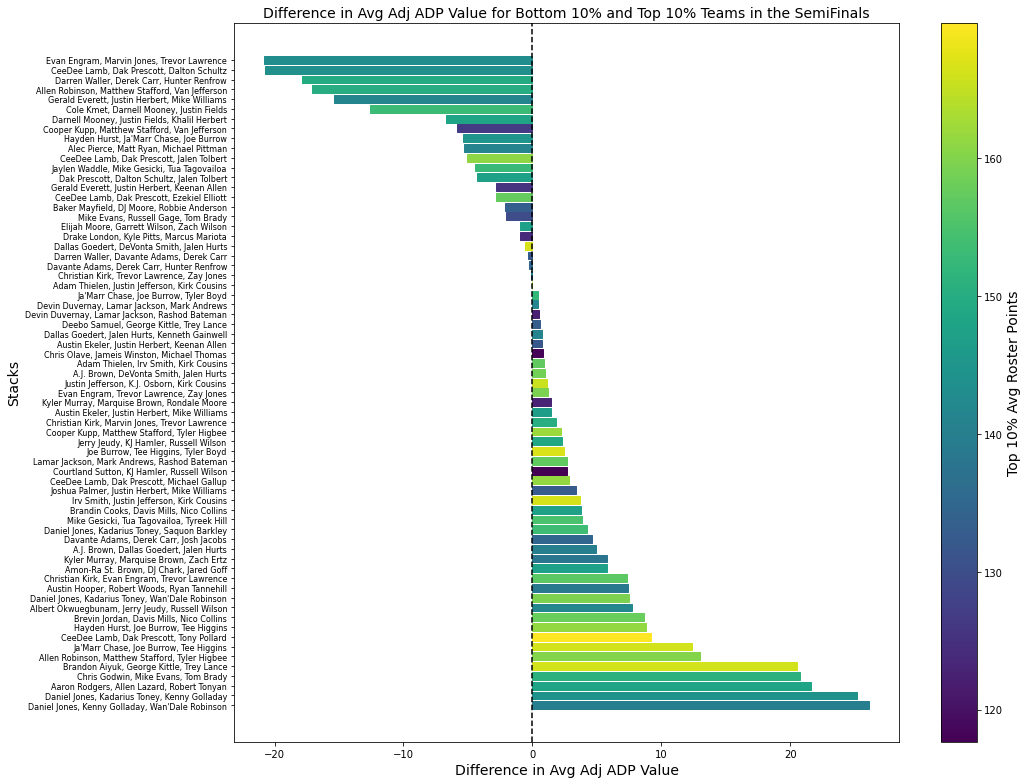

In [36]:
filtered_merged_df = merged_df.dropna(subset=['SemiFinals ADP Diff'])
filtered_merged_df_sorted = filtered_merged_df.sort_values(by='SemiFinals ADP Diff', ascending=False)
filtered_merged_df_sorted = filtered_merged_df_sorted.reset_index()
plt.figure(figsize=(15, 11))
bars = plt.barh(filtered_merged_df_sorted['player_names'], filtered_merged_df_sorted['SemiFinals ADP Diff'])

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=filtered_merged_df_sorted['Semi Top 10% Avg Roster Points'].min(),
                     vmax=filtered_merged_df_sorted['Semi Top 10% Avg Roster Points'].max())
for bar, color in zip(bars, cmap(norm(filtered_merged_df_sorted['Semi Top 10% Avg Roster Points']))):
    bar.set_color(color)

plt.title('Difference in Avg Adj ADP Value for Bottom 10% and Top 10% Teams in the SemiFinals',fontsize=14)
plt.xlabel('Difference in Avg Adj ADP Value',fontsize=14)
plt.ylabel('Stacks',fontsize=14)

# Draw a vertical line at x = 0
plt.axvline(x=0, color='black', linestyle='--')

plt.yticks(np.arange(len(filtered_merged_df_sorted)), filtered_merged_df_sorted['player_names'], fontsize=8)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Top 10% Avg Roster Points',fontsize=14)

plt.tight_layout()
plt.show()


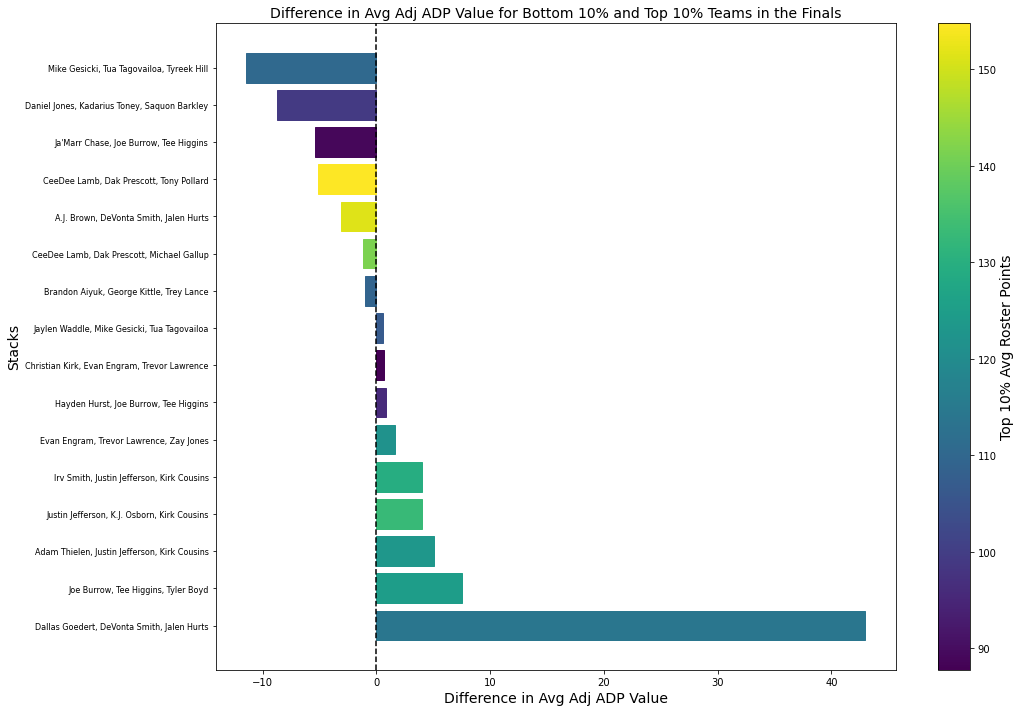

In [37]:
filtered_merged_df = merged_df.dropna(subset=['Finals ADP Diff'])
filtered_merged_df_sorted = filtered_merged_df.sort_values(by='Finals ADP Diff', ascending=False)
filtered_merged_df_sorted = filtered_merged_df_sorted.reset_index()

plt.figure(figsize=(15, 10))
bars = plt.barh(filtered_merged_df_sorted['player_names'], filtered_merged_df_sorted['Finals ADP Diff'])

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=filtered_merged_df_sorted['Finals Top 10% Avg Roster Points'].min(),
                     vmax=filtered_merged_df_sorted['Finals Top 10% Avg Roster Points'].max())
for bar, color in zip(bars, cmap(norm(filtered_merged_df_sorted['Finals Top 10% Avg Roster Points']))):
    bar.set_color(color)

plt.title('Difference in Avg Adj ADP Value for Bottom 10% and Top 10% Teams in the Finals',fontsize=14)
plt.xlabel('Difference in Avg Adj ADP Value',fontsize=14)
plt.ylabel('Stacks',fontsize=14)

# Draw a vertical line at x = 0
plt.axvline(x=0, color='black', linestyle='--')

plt.yticks(np.arange(len(filtered_merged_df_sorted)), filtered_merged_df_sorted['player_names'], fontsize=8)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Top 10% Avg Roster Points',fontsize=14)

plt.tight_layout()
plt.show()


## Conclusion

The analysis done covered several topics related to how to approach stacking in your drafts, but also how ADP value affects team performance within those stacks. While there is no defined approach that will guarantee advancement and playoff success, there were a few things that are important to remember when drafting.

First, it is rarely a good idea to have stacks that consist of more than 5 players, and the bigger it gets the more ADP value needs to be considered. 

Second, and arguably the most surprising finding, is the benefits of having a QB be apart of your stack and the fact that reaching for that QB have major negative impact on team performance. Having the QB raises your chance of hitting an expected advance rate regardless of ADP value on the stack, and has the potential to create very strong teams in the regular season and playoffs if you get a large ADP value on the stack as a whole. 

Third, when it comes to stacking your early picks, don't worry about ADP value. If you think Jalen Hurts+AJ Brown+Devonta Smith is the key this season just draft them wherever you can. If you do not have that conviction though it does not seem like a great idea to have many teams built with stacks from the early rounds.

Fourth, having ADP value on a specific stack can help you have a top 10% team with that stack in the regular season, but the data does not necessarily show that to be true throughout the playoffs. At the end of the day it is up to the drafter to determine how much they value regular season advance rate vs completing stacks for the playoff weeks. It never bad to get ADP value on a stack, but it may be worth it to reach at times to ensure you get the stack to benefit playoff weeks performance.